# Проект: Прогнозная модель для оптимального отбора коров

**Описание проекта**

В рамках данного проекта будут разработны и внедрены две прогнозные модели на основе предоставленных от заказчика данных об имеющемся стаде, а также данных от «ЭкоФермы», где планируется покупка новых коров. Эти модели позволят перейти от субъективной оценки к объективному и управляемому рисками подходу при отборе потенциальных бурёнок. Модели помогут точно определить, какие коровы максимально соответствуют строгим критериям качества молока и продуктивности.

**Цель исследования**

Основная цель проекта — создание интеллектуальной системы поддержки принятия решений для закупки коров, которая позволит:

- Надежно прогнозировать будущий удой каждой коровы в килограммах молока в год.
- Оценивать вероятность получения вкусного молока от каждой коровы согласно уникальным критериям заказчика.
- Отобрать только тех коров, которые отвечают двум ключевым требованиям:
  - Средний удой за год не менее 6000 килограммов;
  - Молоко должно быть вкусным (с высокой вероятностью).

**Ход исследования**

Для достижения поставленных целей будут выполнены следующие шаги:

- Первичный анализ предобработка данных;
- Исследовательский анализ данных;
- Корреляционный анализ;
- Обучение модели линейной регрессии для предсказания удоя;
- Обучение модели логистической регрессии для предсказания вкуса молока;
- Применение моделей к имеющимся данным и отбор лучших коров, рекомендованных к покупке;

Также в заключительной части проекта будут сформулированы итоговые выводы и рекомендации для заказчика.

## Настойка среды

In [1]:
# устанавливаем библиотеку
!pip install phik -q

In [2]:
# импорт основных библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from phik import phik_matrix

In [3]:
# импорт функций для МО
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    recall_score, 
    precision_score, 
    accuracy_score, 
    confusion_matrix, 
    precision_recall_curve,
    mean_absolute_error, 
    mean_squared_error, 
    r2_score
)

# константа для фиксации случайных значений
RANDOM_STATE = 42

## Ознакомление с данными

In [4]:
# сохраняем датасеты в переменные
farm_data = pd.read_csv('ferma_main.csv', sep=';', decimal=',') # инфо об имеющемся стаде
dads_data = pd.read_csv('ferma_dad.csv', sep=';', decimal=',') # инфо о папах коров имеющегося стада
ecofarm_data = pd.read_csv('cow_buy.csv', sep=';', decimal=',') # инфо о продающихся коровах ЭкоФермы

### Данные об имеющемся стаде

In [5]:
# ознакомление с датасетом
farm_data.head(10)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет
5,6,5254,12.7,1806,0.885,РефлешнСоверинг,Холмистое,Соверин,3.13,3.078,вкусно,менее_2_лет
6,7,5910,13.2,1792,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.48,3.077,вкусно,более_2_лет
7,8,6179,14.7,1806,0.930,Вис Бик Айдиал,Равнинные,Айдиал,3.55,3.076,вкусно,более_2_лет
8,9,6783,14.2,1918,0.940,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.077,вкусно,более_2_лет
9,10,5339,13.4,1791,0.895,Вис Бик Айдиал,Холмистое,Соверин,3.13,3.075,вкусно,менее_2_лет


In [6]:
# общая информация о данных
farm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

In [7]:
# размерность таблицы
farm_data.shape

(634, 12)

In [8]:
# статистическое описание данных
farm_data.describe()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Жирность,%","Белок,%"
count,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000
mean,317.460568,6187.025237,14.542744,1922.682965,0.912855,3.603943,3.075666
std,183.096982,1638.401021,1.301301,182.392548,0.032209,0.168020,0.002540
min,1.000000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,159.250000,5751.750000,13.500000,1772.250000,0.890000,3.590000,3.074000
50%,317.500000,6130.500000,14.700000,1880.500000,0.930000,3.650000,3.076000
75%,475.750000,6501.000000,15.600000,2058.750000,0.940000,3.720000,3.077000
max,629.000000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


### Данные об отцах коров

In [9]:
# ознакомление с датасетом
dads_data.head(10)

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
5,6,Барин
6,7,Соловчик
7,8,Геркулес
8,9,Буйный
9,10,Барин


In [10]:
# общая информация о данных
dads_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [11]:
# размерность таблицы
dads_data.shape

(629, 2)

In [12]:
# статистическое описание данных
dads_data.describe()

,id
count,629.00000
mean,315.00000
std,181.72094
min,1.00000
25%,158.00000
50%,315.00000
75%,472.00000
max,629.00000


### Данные о коровах "ЭкоФермы"

In [13]:
# ознакомление с датасетом
ecofarm_data.head(10)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет


In [14]:
# общая информация о данных
ecofarm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [15]:
# размерность таблицы
ecofarm_data.shape

(20, 7)

In [16]:
# статистическое описание данных
ecofarm_data.describe()

,"Текущая_жирность,%","Текущий_уровень_белок,%"
count,20.000000,20.000000
mean,3.577500,3.069500
std,0.126818,0.010339
min,3.340000,3.046000
25%,3.510000,3.064000
50%,3.590000,3.074000
75%,3.650000,3.076000
max,3.770000,3.081000


<div style="border: 2px solid black; padding: 10px;">
  <strong>На этапе предобработки требуется:</strong>
  <ul> 
    <li>Изменить названия столбцов;</li>
    <li>Проверить датафрейм на наличие явных и неявных дубликатов и устранить их;</li> 
    <li>Проверить датафрейм на наличие пропусков и устранить их.</li> 
  
  После предобработки данные будут пригодны для дальнейшего анализа.  
  </ul>
</div>

##  Предобработка данных

### Изменение названий столбцов

Для удобства при работе с данными изменим названия столбцов:

#### Данные об имеющемся стаде

In [17]:
# для удобства переименуем столбцы
farm_data.rename(columns={
    'Удой, кг': 'milk_kg',
    'ЭКЕ (Энергетическая кормовая единица)': 'feed_energy',
    'Сырой протеин, г': 'raw_protein_g',
    'СПО (Сахаро-протеиновое соотношение)': 'sugar_protein_ratio',
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'father_breed',
    'Жирность,%': 'fat_percent',
    'Белок,%': 'protein_percent',
    'Вкус молока': 'milk_taste',
    'Возраст': 'age_group'
}, inplace=True)

# ознакомление с датасетом после изменений
farm_data.head(1)

,id,milk_kg,feed_energy,raw_protein_g,sugar_protein_ratio,breed,pasture_type,father_breed,fat_percent,protein_percent,milk_taste,age_group
0,1,5863,14.2,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет


**Описание данных**

- **id** - уникальный идентификатор коровы
- **milk_kg** - масса молока, которую корова даёт в год (в килограммах)
- **feed_energy** - энергетическая кормовая единица (ЭКЕ), показатель питательности корма коровы
- **raw_protein_g** - содержание сырого протеина в корме (в граммах)
- **sugar_protein_ratio** - сахаро-протеиновое соотношение (СПО), отношение сахара к протеину в корме коровы
- **breed** - порода коровы
- **pasture_type** - ландшафт лугов, на которых паслась корова
- **father_breed** - порода папы коровы
- **fat_percent** - содержание жиров в молоке (в процентах)
- **protein_percent** - содержание белков в молоке (в процентах)
- **milk_taste** - оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно)
- **age_group** - возраст коровы, бинарный признак (менее_2_лет, более_2_лет)

#### Данные об отцах коров

In [18]:
# для удобства переименуем столбец
dads_data.rename(columns={'Имя Папы': 'father_name'}, inplace=True)

# ознакомление с датасетом после изменений
dads_data.head(1)

,id,father_name
0,1,Буйный


**Описание данных**

- **id** - уникальный идентификатор коровы
- **father_name** - имя папы коровы

#### Данные о коровах "ЭкоФермы"

In [19]:
# для удобства переименуем столбцы
ecofarm_data.rename(columns={
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'father_breed',
    'Имя_папы': 'father_name',
    'Текущая_жирность,%': 'fat_percent',
    'Текущий_уровень_белок,%': 'protein_percent',
    'Возраст': 'age_group'
}, inplace=True)

# ознакомление с датасетом после изменений
ecofarm_data.head(1)

,breed,pasture_type,father_breed,father_name,fat_percent,protein_percent,age_group
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет


**Описание данных**

- **breed** - порода коровы
- **pasture_type** - ландшафт лугов, на которых паслась корова
- **father_breed** - порода папы коровы
- **father_name** - имя папы коровы
- **fat_percent** - содержание жиров в молоке (в процентах)
- **protein_percent** - содержание белков в молоке (в процентах)
- **age_group** - возраст коровы, бинарный признак (менее_2_лет, более_2_лет)

### Обработка дубликатов

Сначала проверим датасет на наличие явных дубликатов, затем вручную найдем и обработаем неявные дубликаты в других строковых столбцах.

In [20]:
# проверяем данные на наличие явных дубликатов
print(f"Количество явных дубликатов в farm_data: {farm_data.duplicated().sum()}")
print(f"Количество явных дубликатов в dads_data: {dads_data.duplicated().sum()}")
print(f"Количество явных дубликатов в ecofarm_data: {ecofarm_data.duplicated().sum()}")

Количество явных дубликатов в farm_data: 5
Количество явных дубликатов в dads_data: 0
Количество явных дубликатов в ecofarm_data: 4


В основном датафрейме farm_data есть 5 дубликатов с одинаковым id - их можно смело удалить. Что касается данных "ЭкоФермы", то дубликаты в них удалять не стоит: самих данных и характеристик меньше (к тому же нет id), так что это вполне могут быть разные коровы.

In [21]:
# удаляем дубликаты
farm_data = farm_data.drop_duplicates()

# проверим наличие дубликатов
farm_data.duplicated().sum()

np.int64(0)

Теперь проверим датасеты на наличие неявных дубликатов:

In [22]:
# категориальные столбцы
cat_columns = ['breed', 'pasture_type', 'father_breed', 'father_name', 'age_group', 'milk_taste']

# словарь датафреймов
dataframes = {
    "farm_data": farm_data,
    "dads_data": dads_data,
    "ecofarm_data": ecofarm_data
}

# проверим уникальные значения некоторых столбцов
for name, df in dataframes.items():
    print(f'Уникальные значения в столбцах {name}:')
    for category in cat_columns:
        if category in df.columns:
            print(f'{category}: {df[category].dropna().sort_values().unique()}')
    print()

Уникальные значения в столбцах farm_data:
breed: ['Вис Бик Айдиал' 'РефлешнСоверинг']
pasture_type: ['Равнинное' 'Равнинные' 'Холмистое']
father_breed: ['Айдиал' 'Айдиалл' 'Соверин']
age_group: ['более_2_лет' 'менее_2_лет']
milk_taste: ['вкусно' 'не вкусно']

Уникальные значения в столбцах dads_data:
father_name: ['Барин' 'Буйный' 'Геркулес' 'Соловчик']

Уникальные значения в столбцах ecofarm_data:
breed: ['Вис Бик Айдиал' 'РефлешнСоверинг']
pasture_type: ['равнинное' 'холмистое']
father_breed: ['Айдиал' 'Соверин']
father_name: ['Барин' 'Буйный' 'Геркулес' 'Соловчик']
age_group: ['более_2_лет' 'менее_2_лет']



Неявные дубликаты найдены в столбцах **pasture_type** и **father_breed**. Исправим ошибки и согласуем написание названий пород и пастбищ между датасетами:

In [23]:
# заменяем неявные дубликаты на корректные значения
farm_data['pasture_type'] = farm_data['pasture_type'].replace(['Равнинное', 'Равнинные'], 'равнинное')
farm_data['pasture_type'] = farm_data['pasture_type'].replace('Холмистое', 'холмистое')
farm_data['father_breed'] = farm_data['father_breed'].replace('Айдиалл', 'Айдиал')

# еще раз проверим уникальные значения столбцов
for name, df in dataframes.items():
    print(f'Уникальные значения в столбцах {name}:')
    for category in cat_columns:
        if category in df.columns:
            print(f'{category}: {df[category].dropna().sort_values().unique()}')
    print()

Уникальные значения в столбцах farm_data:
breed: ['Вис Бик Айдиал' 'РефлешнСоверинг']
pasture_type: ['равнинное' 'холмистое']
father_breed: ['Айдиал' 'Соверин']
age_group: ['более_2_лет' 'менее_2_лет']
milk_taste: ['вкусно' 'не вкусно']

Уникальные значения в столбцах dads_data:
father_name: ['Барин' 'Буйный' 'Геркулес' 'Соловчик']

Уникальные значения в столбцах ecofarm_data:
breed: ['Вис Бик Айдиал' 'РефлешнСоверинг']
pasture_type: ['равнинное' 'холмистое']
father_breed: ['Айдиал' 'Соверин']
father_name: ['Барин' 'Буйный' 'Геркулес' 'Соловчик']
age_group: ['более_2_лет' 'менее_2_лет']



### Обработка пропусков

In [24]:
# проверяем количество пропусков в данных
farm_data.isna().sum()

id                     0
milk_kg                0
feed_energy            0
raw_protein_g          0
sugar_protein_ratio    0
breed                  0
pasture_type           0
father_breed           0
fat_percent            0
protein_percent        0
milk_taste             0
age_group              0
dtype: int64

In [25]:
dads_data.isna().sum()

id             0
father_name    0
dtype: int64

In [26]:
ecofarm_data.isna().sum()

breed              0
pasture_type       0
father_breed       0
father_name        0
fat_percent        0
protein_percent    0
age_group          0
dtype: int64

В данных отсутствуют пропуски.

### Изменение типов данных

In [27]:
# проверяем типы данных в farm_data
farm_data.dtypes

id                       int64
milk_kg                  int64
feed_energy            float64
raw_protein_g            int64
sugar_protein_ratio    float64
breed                   object
pasture_type            object
father_breed            object
fat_percent            float64
protein_percent        float64
milk_taste              object
age_group               object
dtype: object

Все типы данных корректны.

In [28]:
# проверяем типы данных в dads_data
dads_data.dtypes

id              int64
father_name    object
dtype: object

В датасете dads_data изменения не требуются.

In [29]:
# проверяем типы данных в ecofarm_data
ecofarm_data.dtypes

breed               object
pasture_type        object
father_breed        object
father_name         object
fat_percent        float64
protein_percent    float64
age_group           object
dtype: object

Все типы данных корректны.

### Объединение данных об имеющемся стаде

Объединение датафреймов с информацией об имеющемся стаде **farm_data** и **dads_data** упростит проведение исследовательского анализа данных и может пригодиться для моделей. Сделаем это, сохранив данные в отдельный датафрейм **farm_total**:

In [30]:
# проверим размерность до объединения
print(farm_data.shape)   
print(dads_data.shape)   

(629, 12)
(629, 2)


In [31]:
# объединение по 'id'
farm_total = farm_data.merge(dads_data, on='id', how='left')

# снова проверяем размерность
farm_total.shape

(629, 13)

In [32]:
# проверяем наличие пропусков
farm_total.isna().sum()

id                     0
milk_kg                0
feed_energy            0
raw_protein_g          0
sugar_protein_ratio    0
breed                  0
pasture_type           0
father_breed           0
fat_percent            0
protein_percent        0
milk_taste             0
age_group              0
father_name            0
dtype: int64

<div style="border: 2px solid black; padding: 10px;">
  <strong>Итоги:</strong>
  <ul>
    <li>Изменены названия столбцов в датасетах;</li>
    <li>Явные дубликаты устранены там, где это необходимо;</li>
    <li>Устранены неявные дубликаты в категориальных столбцах;</li>  
    <li>Пропуски в данных отсутствуют;</li> 
    <li>Изменение типа данных не требуется;</li> 
    <li>Объединены данные об имеющемся стаде (датафреймы farm_data и dads_data) в новый датафрейм - farm_total.</li>   
  
  Теперь данные готовы к исследовательскому анализу.  
  </ul>
</div>

## Исследовательский анализ данных

На данном этапе мы проведем статистический анализ всех признаков, а также построим графики для каждого из них с учетом того, что количественным и категориальным признакам подходят разные способы визуализации. Это поможет заметить выбросы, необычное распределение количественных признаков и другие особенности с целью улучшить данные и подготовить их к моделированию.

### Данные об имеющемся стаде (farm_total)

Рассмотрим сразу все признаки относящиеся к текущему стаду (объедененный датафрейм **farm_total**). Для удобства разделим исследуемые признаки на количественные и категориальные:

In [33]:
# разделим признаки
num_cols = farm_total.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = farm_total.select_dtypes(include=['object']).columns.tolist()

print("Количественные признаки:", num_cols)
print("Категориальные признаки:", cat_cols)

Количественные признаки: ['id', 'milk_kg', 'feed_energy', 'raw_protein_g', 'sugar_protein_ratio', 'fat_percent', 'protein_percent']
Категориальные признаки: ['breed', 'pasture_type', 'father_breed', 'milk_taste', 'age_group', 'father_name']


Начнем с исследования количественных признаков:

In [34]:
# статистическое описание количественных признаков
farm_total[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
id,629.0,315.000000,181.720940,1.000,158.000,315.000,472.000,629.000
milk_kg,629.0,6188.750397,1644.795489,5204.000,5751.000,6133.000,6501.000,45616.000
feed_energy,629.0,14.543879,1.306408,10.900,13.500,14.700,15.600,16.800
raw_protein_g,629.0,1923.364070,182.956251,1660.000,1771.000,1888.000,2062.000,2349.000
sugar_protein_ratio,629.0,0.913116,0.032203,0.840,0.890,0.930,0.940,0.960
fat_percent,629.0,3.603657,0.168656,2.990,3.590,3.650,3.720,3.750
protein_percent,629.0,3.075671,0.002549,3.069,3.074,3.076,3.077,3.085


В статистическом описании признака **milk_kg** был обнаружен явный выброс: значение 45616 кг при среднем значении около 6190 кг и 75-м процентиле около 6500 кг. Это значение более чем в 7 раз превышает среднее и не соответствует реальным биологическим возможностям. Это указывает на возможную ошибку ввода или единиц измерения, которую стоит удалить из датасетов:

In [35]:
# убедимся, что выброс один
farm_total['milk_kg'].sort_values(ascending=False).head()

16     45616
70      7222
135     7207
296     7201
294     7197
Name: milk_kg, dtype: int64

In [36]:
# узнаем id строки
farm_total[farm_data['milk_kg'] == 45616]

,id,milk_kg,feed_energy,raw_protein_g,sugar_protein_ratio,breed,pasture_type,father_breed,fat_percent,protein_percent,milk_taste,age_group,father_name
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет,Буйный


In [37]:
# удаляем этот выброс из всех данных о текущем стаде для сохранения размерности
farm_total = farm_total[farm_total['milk_kg'] != 45616].copy()
farm_data = farm_data[farm_data['milk_kg'] != 45616].copy()
dads_data = dads_data[dads_data['id'] != 17].copy()

# проверяем наличие выброса
farm_total['milk_kg'].sort_values(ascending=False).head()

70     7222
135    7207
296    7201
294    7197
593    7174
Name: milk_kg, dtype: int64

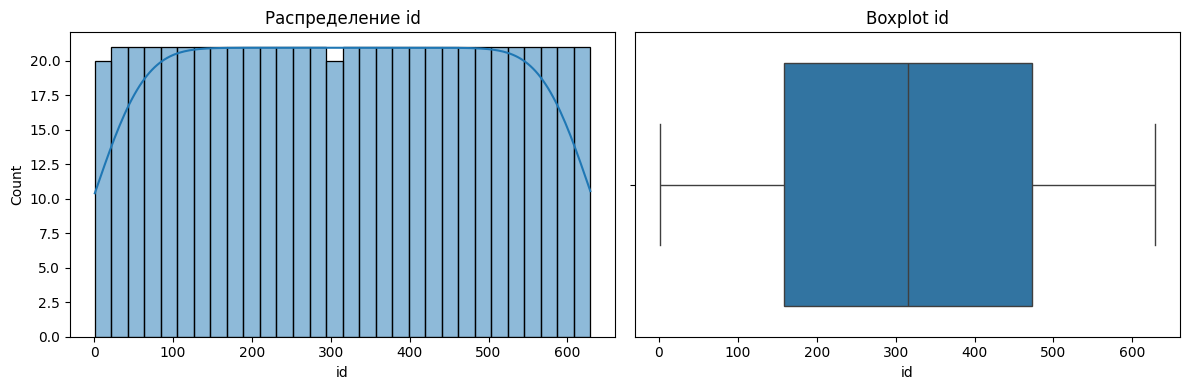

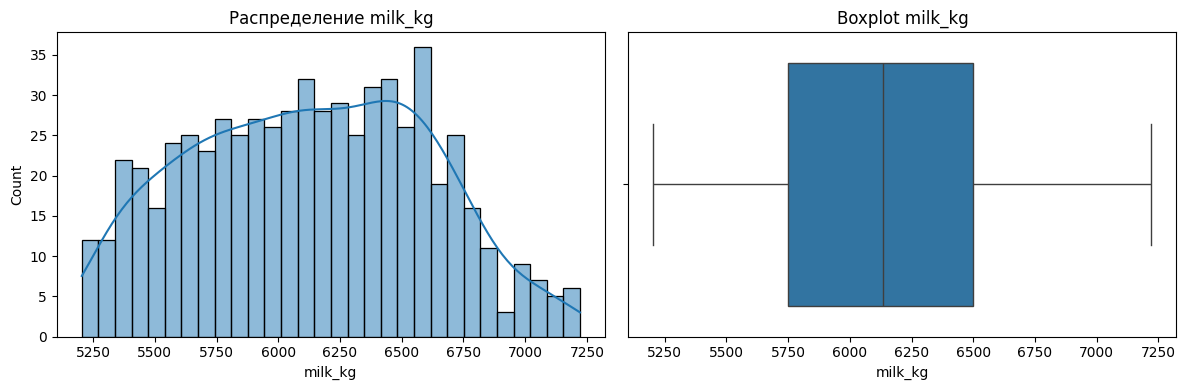

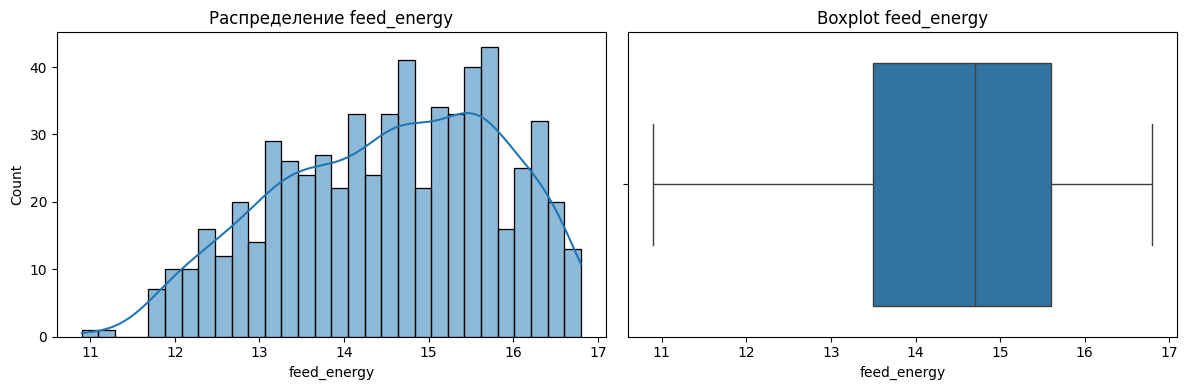

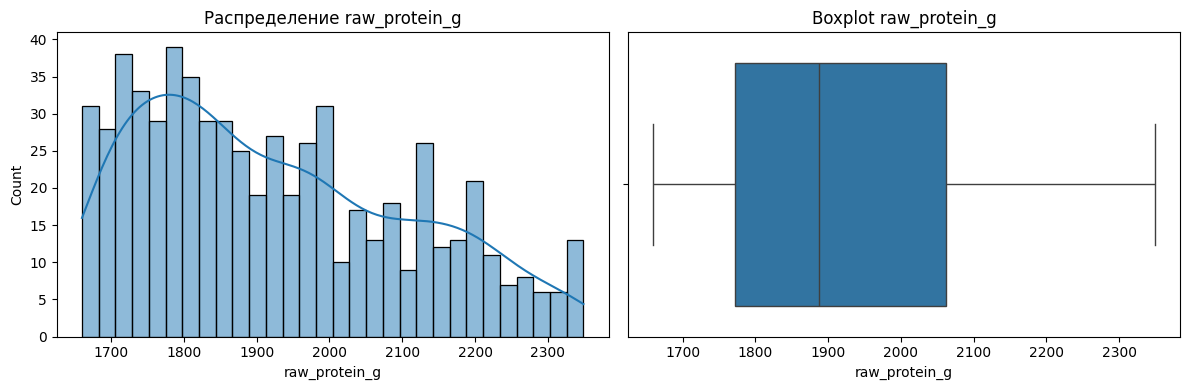

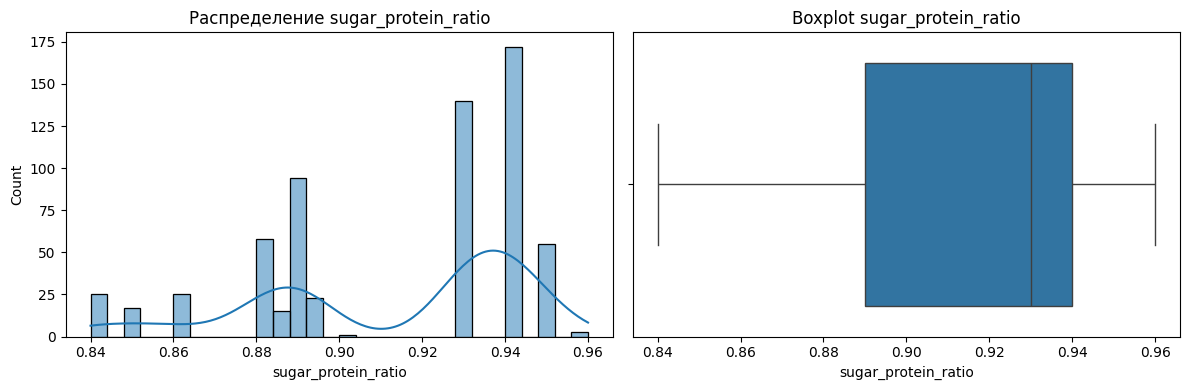

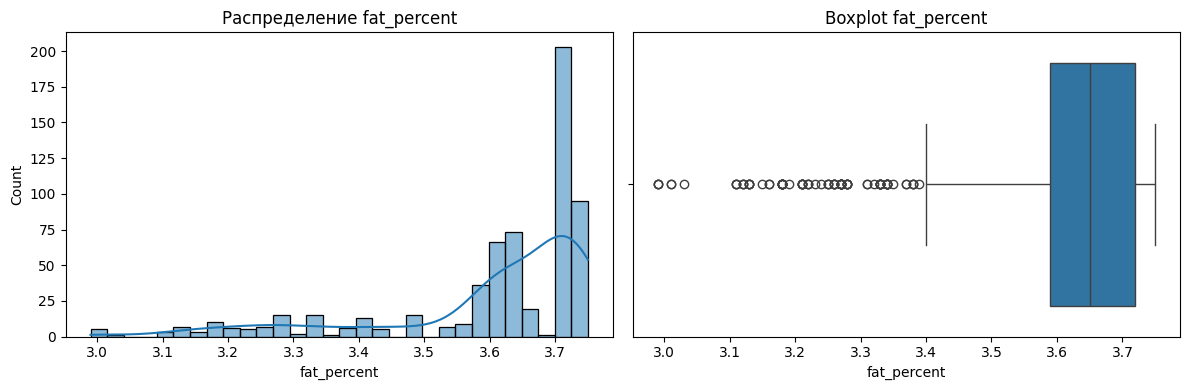

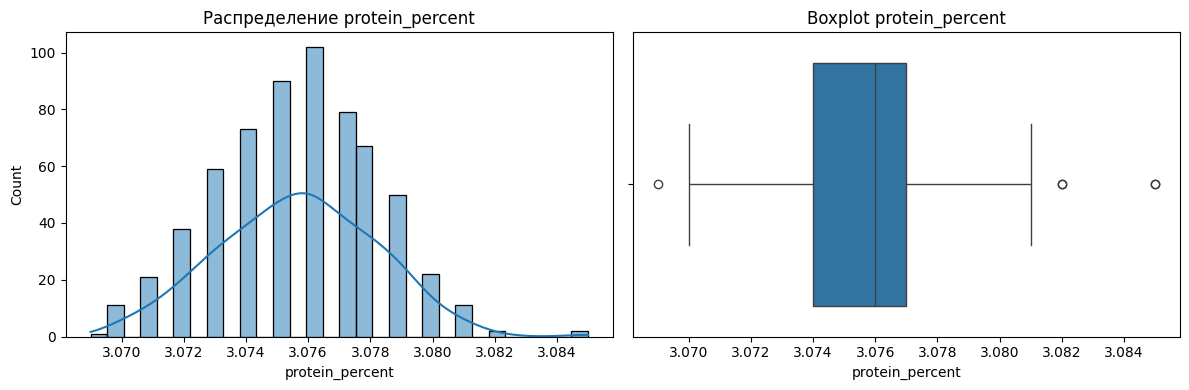

In [38]:
# строим распределения и boxplot для признаков
for col in num_cols:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(farm_total[col], kde=True, bins=30)
    plt.title(f'Распределение {col}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=farm_total[col])
    plt.title(f'Boxplot {col}')

    plt.tight_layout()
    plt.show()

<div style="border: 2px solid black; padding: 10px;">
  <strong>Наблюдения по количественным значениям farm_total:</strong>
  <ul>
    <li><strong>id:</strong> Неинформативный признак, просто уникальный идентификатор. Есть смысл исключить из анализа и моделей.</li>
    <li><strong>milk_kg:</strong> Признак содержал выброс (значение в 7 раз выше среднего), который был удален. После удаления аномального значения распределение стало ближе к нормальному без других выбросов.</li>
    <li><strong>feed_enegry:</strong> Признак нормально распределён, не имеет выбросов, хорошо подходит для модели.</li>  
    <li><strong>raw_protein_g:</strong> Распределение широкое, но без аномалий.</li> 
    <li><strong>sugar_protein_ratio:</strong> Имеет ярко выраженное бимодальное распределение. Это указывает на наличие двух различных кластеров или подгрупп в данных. Это будет важно для модели.</li>
    <li><strong>fat_percent:</strong> Распределение явно скошено влево, с длинным "хвостом" в сторону более низких значений, что говорит о том, что большинство значений высокие, но есть несколько низких выбросов.</li>
    <li><strong>protein_percent:</strong> Распределение нормальное, но почти нет различий между значениями, что говорит о низкой информативности признака.</li>  
  </ul>
</div>

Теперь исследуем категориальные признаки:

In [39]:
# описание категориальных признаков
for col in cat_cols:
    print(f"Уникальные значения {col}:")
    print(farm_total[col].value_counts(dropna=False))
    print()

Уникальные значения breed:
breed
Вис Бик Айдиал     372
РефлешнСоверинг    256
Name: count, dtype: int64

Уникальные значения pasture_type:
pasture_type
холмистое    350
равнинное    278
Name: count, dtype: int64

Уникальные значения father_breed:
father_breed
Айдиал     317
Соверин    311
Name: count, dtype: int64

Уникальные значения milk_taste:
milk_taste
вкусно       370
не вкусно    258
Name: count, dtype: int64

Уникальные значения age_group:
age_group
более_2_лет    518
менее_2_лет    110
Name: count, dtype: int64

Уникальные значения father_name:
father_name
Барин       240
Буйный      214
Соловчик    110
Геркулес     64
Name: count, dtype: int64



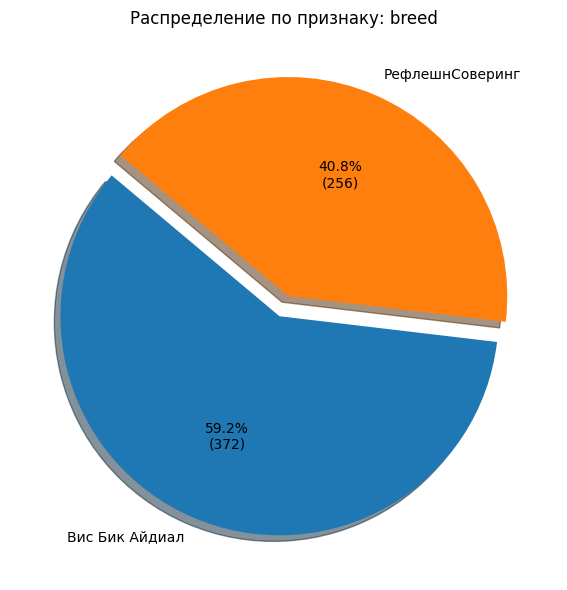

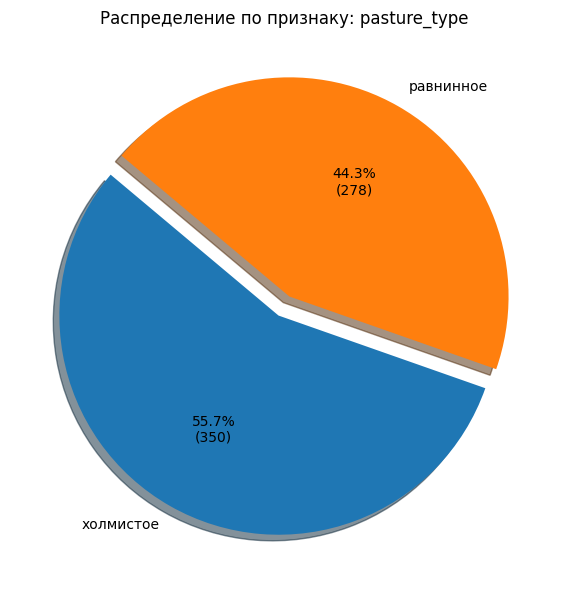

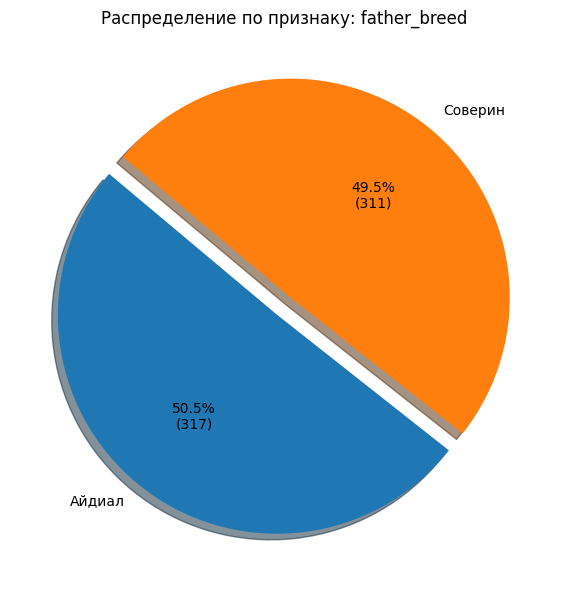

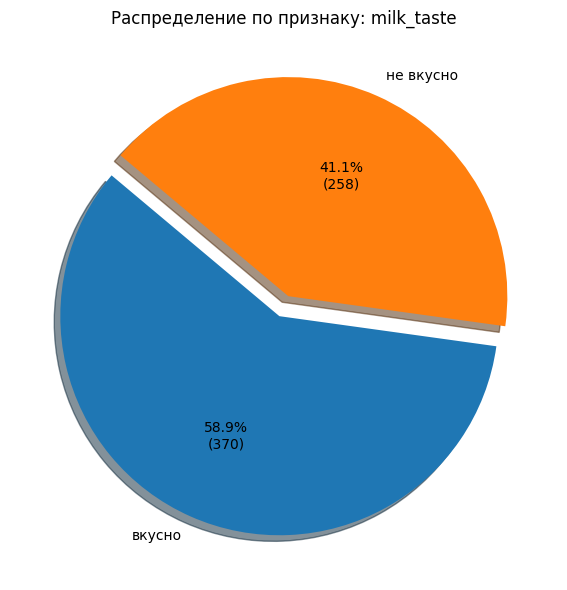

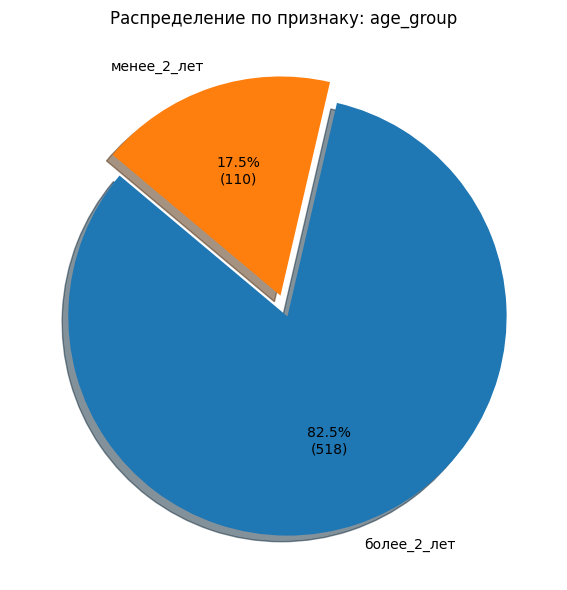

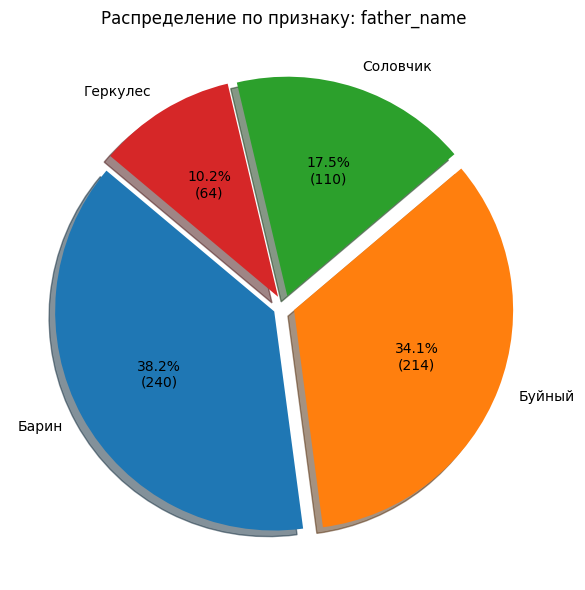

In [40]:
# строим круговые диаграммы для категориальных признаков
for col in cat_cols:
    counts = farm_total[col].value_counts(dropna=False)
    labels = counts.index
    sizes = counts.values
    explode = [0.05] * len(labels) # чуть сдвигаем каждый сектор

    def make_autopct(values): # функция для корректного подсчета абсолютных значений
        def my_autopct(pct):
            total = sum(values)
            absolute = int(round(pct * total / 100.0))
            return f"{pct:.1f}%\n({absolute})"
        return my_autopct

    plt.figure(figsize=(6, 6))
    plt.pie(
        sizes,
        labels=labels,
        autopct=make_autopct(sizes),
        startangle=140,
        explode=explode,
        shadow=True
    )
    plt.title(f'Распределение по признаку: {col}')
    plt.tight_layout()
    plt.show()

<div style="border: 2px solid black; padding: 10px;">
  <strong>Наблюдения по категориальным значениям farm_total:</strong>
  <ul>
    <li><strong>breed:</strong> В имеющемся стаде примерно 59% коров породы "Вис Бик Айдиал" и примерно 41% - "РефлешнСоверинг". Выраженного дисбаланса нет. Нужно проверить, как сильно влияет порода на удой и вкус молока.</li>
    <li><strong>pasture_type:</strong> Холмистые и равнинные пастбища имеют близкое распределение (примерно 56 на 44 соответственно).</li>
    <li><strong>father_breed:</strong> Породы отцов-быков почти идеально сбалансированы (примерно 51% - "Айдиал", 49% - "Соверин"). Это хорошо — признак даст модели обучиться без перекоса.</li>  
    <li><strong>milk_taste:</strong> Во вкусе молока есть небольшой дисбаланс классов, но не критичный (примерно 59% вкусного на 41% невкусного).</li> 
    <li><strong>age_group:</strong> В имеющемся стаде 82.5% коров старше 2 лет, остальные младше. Уже значимый дисбаланс (примерно 5 к 1). Возможно будет необходимо сбалансировать классы.</li>
    <li><strong>father_name:</strong> Четыре категории с умеренным дисбалансом: больше 70% коров текущего стада происходят от быков Барина и Буйного (примерно в равной степени), лишь 10% от Геркулеса, оставшиеся 17.5% от Соловчика.</li>
  </ul>
</div>

### Данные о коровах "ЭкоФермы" (ecofarm_data)

Теперь исследуем данные о коровах, которых фермер хочет купить, и для которых нужно предсказать удой и вкус. Для удобства разделим исследуемые признаки на количественные и категориальные:

In [41]:
# разделим признаки
num_cols = ecofarm_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = ecofarm_data.select_dtypes(include=['object']).columns.tolist()

print("Количественные признаки:", num_cols)
print("Категориальные признаки:", cat_cols)

Количественные признаки: ['fat_percent', 'protein_percent']
Категориальные признаки: ['breed', 'pasture_type', 'father_breed', 'father_name', 'age_group']


Исследуем количественные признаки:

In [42]:
# статистическое описание количественных признаков
ecofarm_data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
fat_percent,20.0,3.5775,0.126818,3.340,3.510,3.590,3.650,3.770
protein_percent,20.0,3.0695,0.010339,3.046,3.064,3.074,3.076,3.081


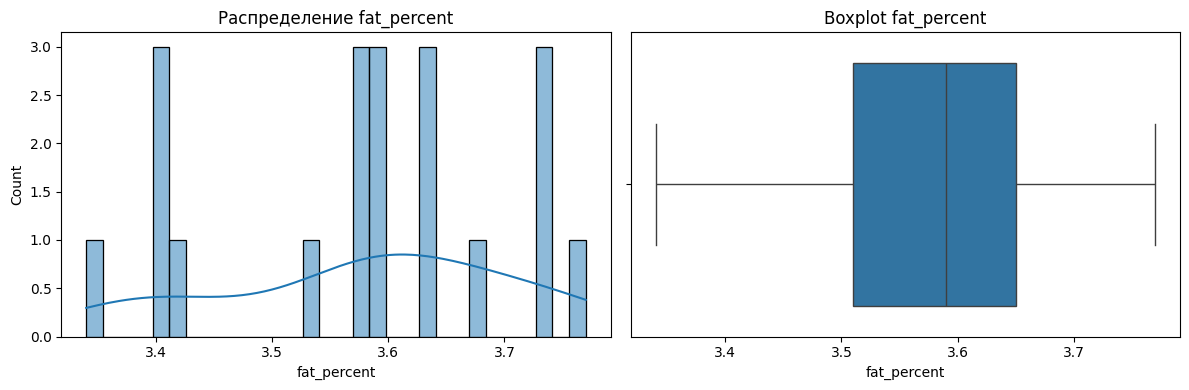

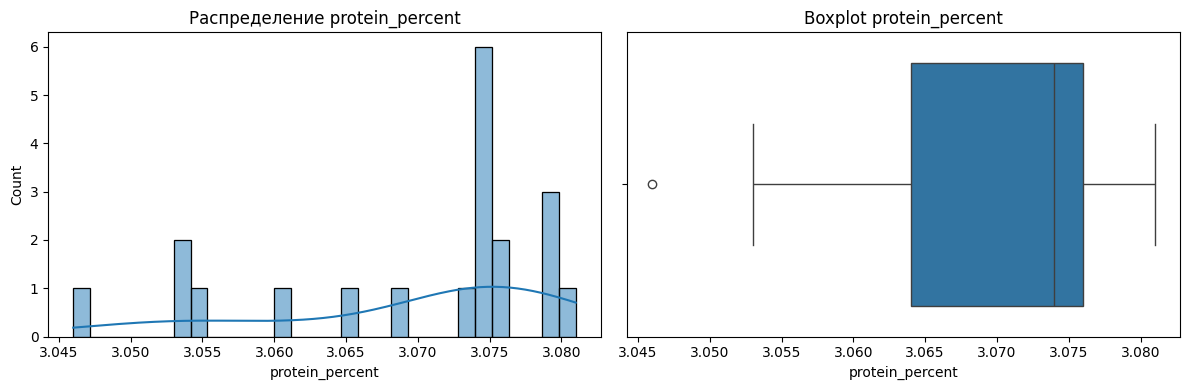

In [43]:
# строим распределения и boxplot для признаков
for col in num_cols:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(ecofarm_data[col], kde=True, bins=30)
    plt.title(f'Распределение {col}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=ecofarm_data[col])
    plt.title(f'Boxplot {col}')

    plt.tight_layout()
    plt.show()

<div style="border: 2px solid black; padding: 10px;">
  <strong>Наблюдения по количественным значениям ecofarm_data:</strong>
  <ul>
    <li>Сразу стоит отметить, что наблюдений мало. Это может сильно влиять на качество выводов и на форму гистограмм, делая их более "зубчатыми" и менее гладкими, чем при большой выборке. Соответственно, нет смысла описывать характер распределения.</li>  
    <li>Зафиксируем, что диапазон значений такой же, как и в соответствующих признаках основной таблицы. Это имеет значение для моделей.</li>
  </ul>
</div>

Исследуем категориальные признаки:

In [44]:
# описание категориальных признаков
for col in cat_cols:
    print(f"Уникальные значения {col}:")
    print(ecofarm_data[col].value_counts(dropna=False))
    print()

Уникальные значения breed:
breed
РефлешнСоверинг    11
Вис Бик Айдиал      9
Name: count, dtype: int64

Уникальные значения pasture_type:
pasture_type
равнинное    11
холмистое     9
Name: count, dtype: int64

Уникальные значения father_breed:
father_breed
Соверин    12
Айдиал      8
Name: count, dtype: int64

Уникальные значения father_name:
father_name
Буйный      8
Геркулес    6
Барин       4
Соловчик    2
Name: count, dtype: int64

Уникальные значения age_group:
age_group
более_2_лет    15
менее_2_лет     5
Name: count, dtype: int64



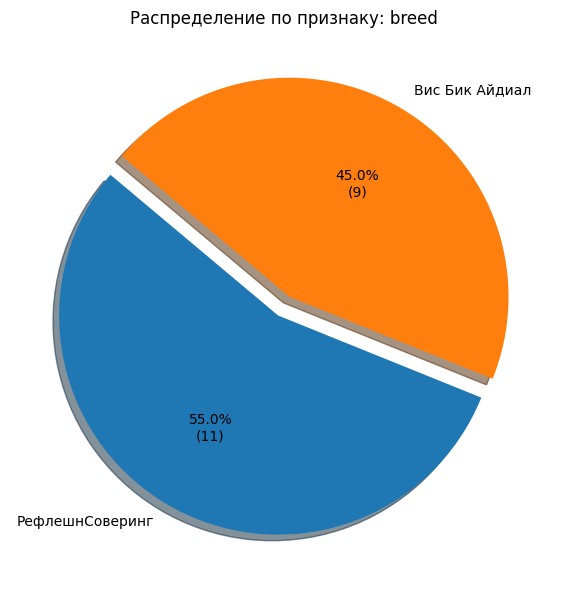

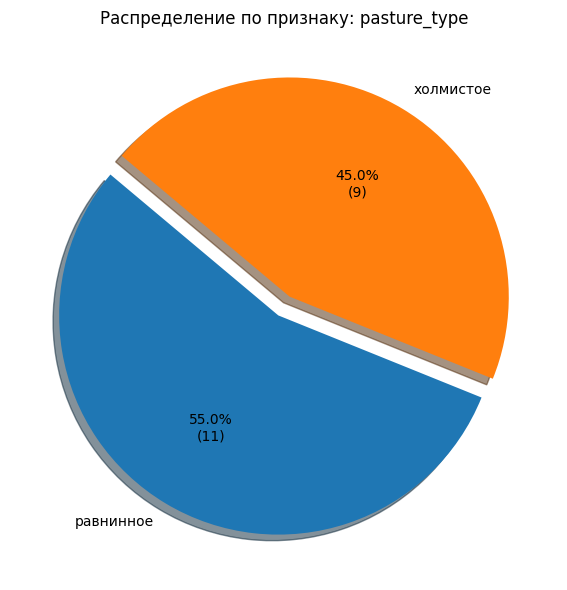

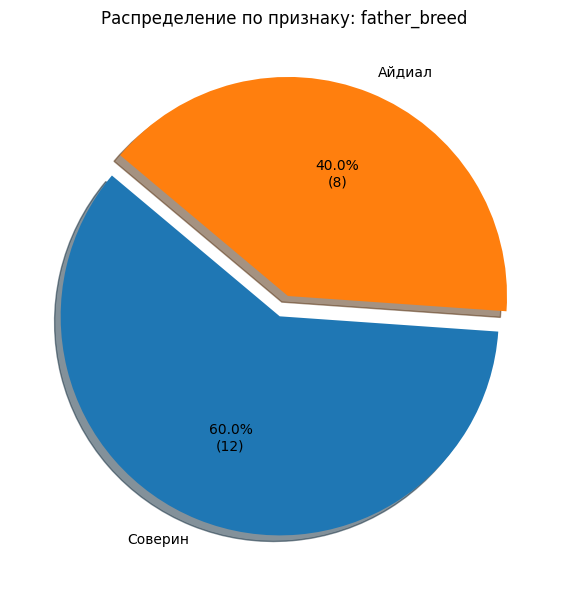

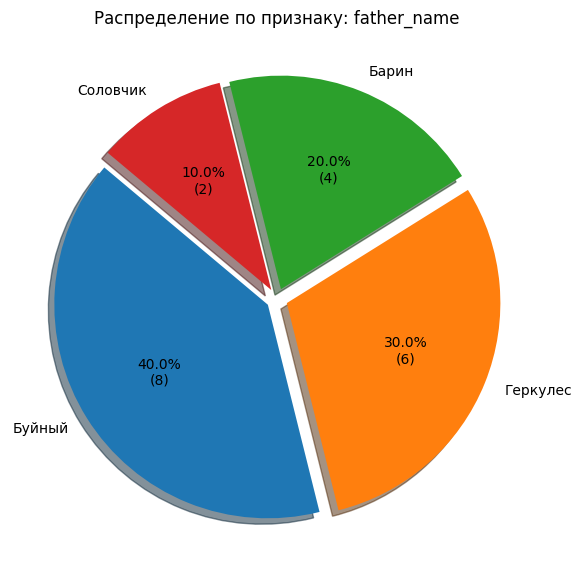

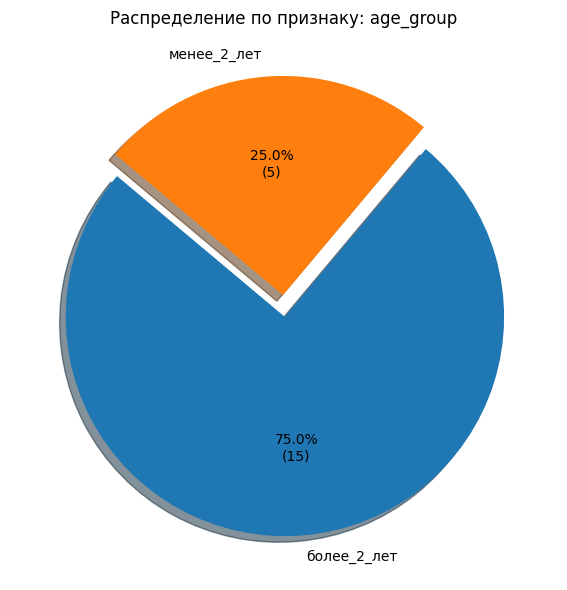

In [45]:
# строим круговые диаграммы для категориальных признаков
for col in cat_cols:
    counts = ecofarm_data[col].value_counts(dropna=False)
    labels = counts.index
    sizes = counts.values
    explode = [0.05] * len(labels) # чуть сдвигаем каждый сектор

    plt.figure(figsize=(6, 6))
    plt.pie(
        sizes,
        labels=labels,
        autopct=make_autopct(sizes),
        startangle=140,
        explode=explode,
        shadow=True
    )
    plt.title(f'Распределение по признаку: {col}')
    plt.tight_layout()
    plt.show()

<div style="border: 2px solid black; padding: 10px;">
  <strong>Наблюдения по категориальным значениям ecofarm_data:</strong>
  <ul>
    <li><strong>breed:</strong> В стаде "ЭкоФермы" примерно поровну коров пород "РефлешнСоверинг" (11) и "Вис Бик Айдиал" (9).</li>
    <li><strong>pasture_type:</strong> В той же пропорции распределены типы пастбищ: равнинных - 11, холмистых - 9.</li>
    <li><strong>father_breed:</strong> Породы быков-отцов распределены 60 на 40: "Соверин" - 12, "Айдиал" - 8.</li>
    <li><strong>father_name:</strong> 70% коров "ЭкоФермы" - потомство Буйного (40%) и Геркулеса (30%). Соловчик и Барин представлены хуже всего по сравнению с имеющимся стадом. Все четыре имени будут и в обучающей выборке на основе данных о текущем стаде.</li>
    <li><strong>age_group:</strong> 75% - коровы старше 2 лет, 25% - младше.</li>
    <li>Что важно для моделей: в сравнении с основной таблицей пропорции похожи, новых признаков нет.</li>  
  </ul>
</div>

## Корреляционный анализ

На данном этапе мы изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками, построим диаграммы рассеяния и проанализируем корреляции. 

Для этого будем рассматривать репрезентативные данные об имеющемся стаде -  **farm_data**.

На этапе исследовательского анализа мы заметили, что не все признаки распределены нормально, поэтому необходимо использовать подходы, которые устойчивы к выбросам и ненормальному распределению. Для этого построим матрицу корреляции по коэффициенту Phi (Phik), которая используется для категориальных признаков или пар числовых-категориальных признаков. Она помогает выявить в том числе нелинейные зависимости. Это важно, чтобы понять влияние категориальных признаков на целевой и избежать потери значимой информации при моделировании:

In [46]:
# выбираем количественные признаки
num_cols = ['milk_kg', 'feed_energy', 'raw_protein_g', 
            'sugar_protein_ratio', 'fat_percent', 'protein_percent']

# вычисляем phik корреляции
phik_corr = farm_data.phik_matrix(interval_cols=num_cols)

phik_corr

,id,milk_kg,feed_energy,raw_protein_g,sugar_protein_ratio,breed,pasture_type,father_breed,fat_percent,protein_percent,milk_taste,age_group
id,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
milk_kg,1.0,1.000000,0.720719,0.463224,0.661359,0.164744,0.279540,0.519915,0.707654,0.058970,0.173122,0.998101
feed_energy,1.0,0.720719,1.000000,0.456484,0.591190,0.123086,0.106758,0.171355,0.715914,0.000000,0.272265,0.771596
raw_protein_g,1.0,0.463224,0.456484,1.000000,0.387188,0.090925,0.096474,0.000000,0.397380,0.202474,0.176480,0.351685
sugar_protein_ratio,1.0,0.661359,0.591190,0.387188,1.000000,0.062660,0.155349,0.425601,0.645581,0.073787,0.572702,0.744410
breed,1.0,0.164744,0.123086,0.090925,0.062660,1.000000,0.213218,0.089330,0.222825,0.361851,0.000000,0.057295
pasture_type,1.0,0.279540,0.106758,0.096474,0.155349,0.213218,1.000000,0.000000,0.000000,0.099908,0.269063,0.128455
father_breed,1.0,0.519915,0.171355,0.000000,0.425601,0.089330,0.000000,1.000000,0.000000,0.134582,0.000000,0.355817
fat_percent,1.0,0.707654,0.715914,0.397380,0.645581,0.222825,0.000000,0.000000,1.000000,0.000000,0.198793,0.677913
protein_percent,1.0,0.058970,0.000000,0.202474,0.073787,0.361851,0.099908,0.134582,0.000000,1.000000,0.143857,0.000000


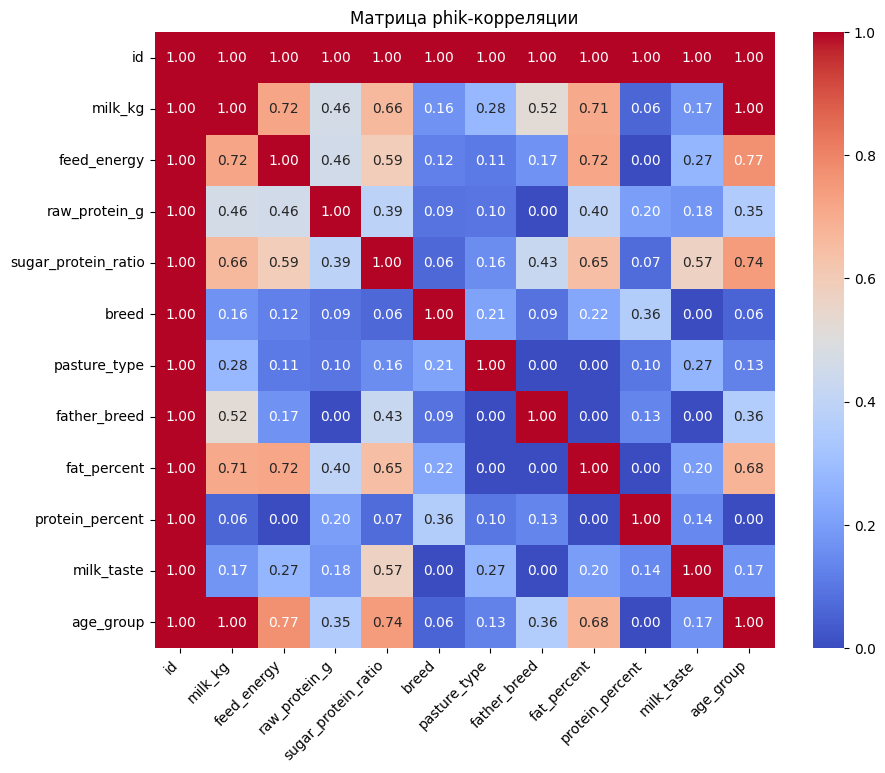

In [47]:
# визуализируем
plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Матрица phik-корреляции")
plt.xticks(rotation=45, ha='right')
plt.show()

**Анализ корреляции между входными признаками (проверка на наличие мультиколлинеарности):**

Тот факт, id имеет такую высокую корреляцию с другими признаками просто подтверждает, что каждый id уникален и однозначно идентифицирует строку данных. Это особенность данных и природы столбца id. Этот признак не будет участвовать в моделировании.

Что касается остальных признаков, то корреляция ниже 0.95 редко приводит к эффектам мультиколлинеарности. К тому же в моделях есть регуляризации, которые борятся с мультиколлинеарностью и при более экстремальных показателях корреляции. Другое дело, что нам в любом случае будет невыгодно брать в модель два признака, которые дублируют друг друга. Но таких в наших данных нет.

<div style="border: 2px solid black; padding: 10px;">
  <strong>Взаимосвязь между удоем (milk_kg) и другими признаками по phik-корреляции:</strong>
  <ul> 
    <li><strong>age_group: 0.998</strong>. Признак хоть и имеет очень высокую корреляцию с целевым, но прямо не связан ним. Так что признак полезен и не должен привести к утечке целевого.</li>  
    <li><strong>feed_energy, fat_percent, sugar_protein_ratio: 0.72-0.66</strong>. Важные для модели признаки.</li>
    <li><strong>father_breed: 0.52</strong>. Умеренная связь: порода отца влияет на удой. Полезно включить в модель.</li>
    <li><strong>raw_protein_g: 0.46</strong>. Умеренная связь: более высокий белок - выше удой. Значим, но не ключевой.</li>
    <li>Остальные признаки имеют очень слабую связь с целевым, если имеют вообще.</li>  
  </ul>
</div>

Теперь построим диаграммы рассеяния для признака **milk_kg** (удой) и всех количественных признаков с учётом значений некоторых категориальных признаков (**breed, father_breed, age_group**):

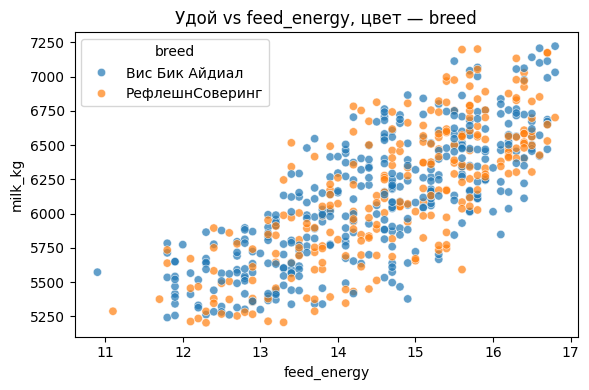

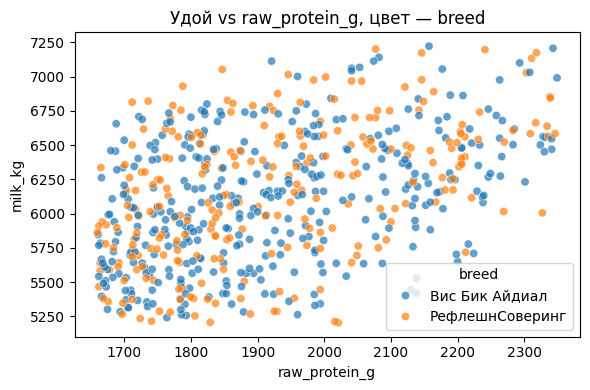

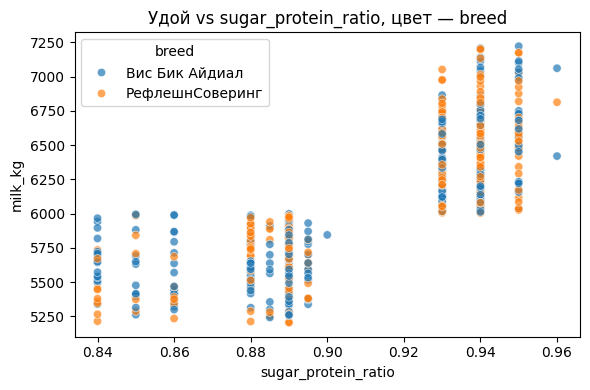

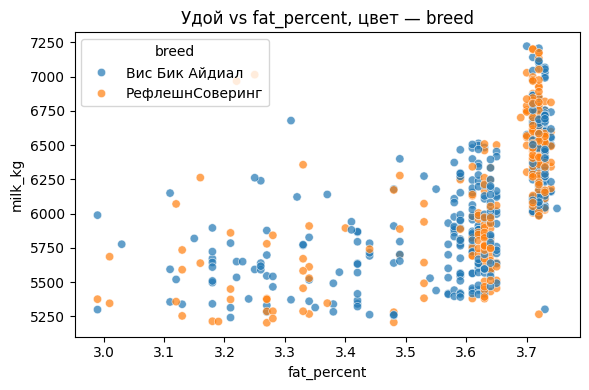

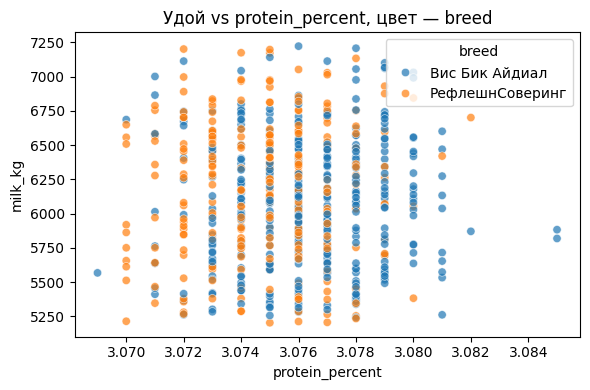

In [48]:
# визуализируем взаимосвязь удоя с другими числовыми признаками с учетом категориального - breed
for feature in num_cols:
    if feature != 'milk_kg':
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=farm_data, x=feature, y='milk_kg', hue='breed', alpha=0.7)
        plt.title(f'Удой vs {feature}, цвет — breed')
        plt.tight_layout()
        plt.show()

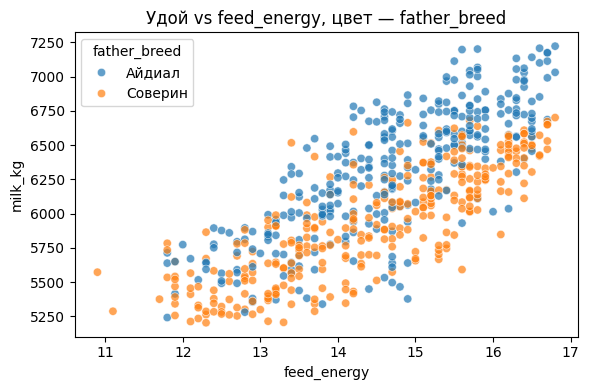

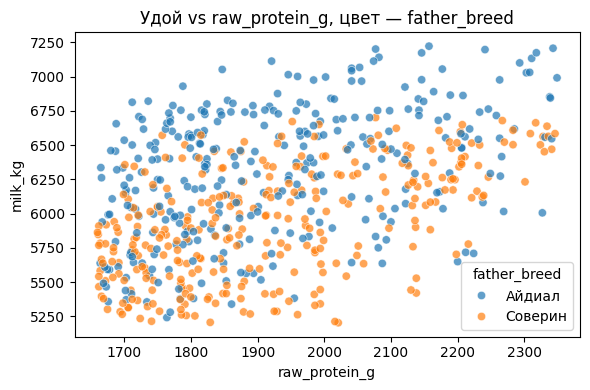

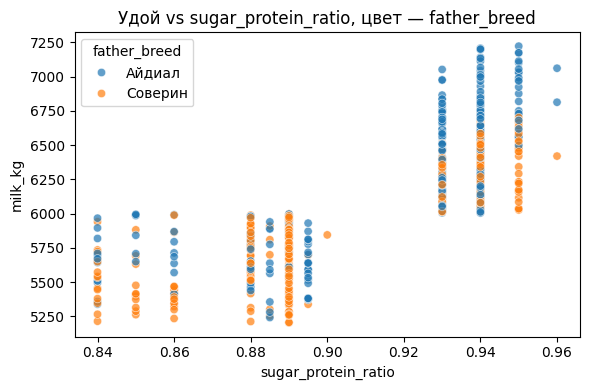

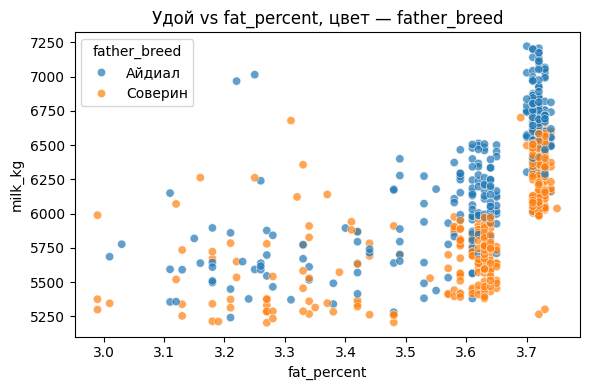

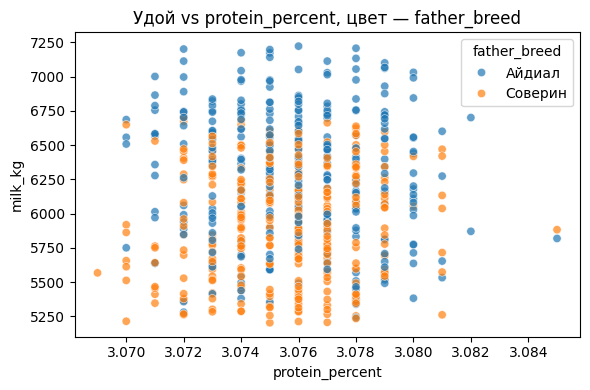

In [49]:
# визуализируем взаимосвязь удоя с другими числовыми признаками с учетом категориального - father_breed
for feature in num_cols:
    if feature != 'milk_kg':
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=farm_data, x=feature, y='milk_kg', hue='father_breed', alpha=0.7)
        plt.title(f'Удой vs {feature}, цвет — father_breed')
        plt.tight_layout()
        plt.show()

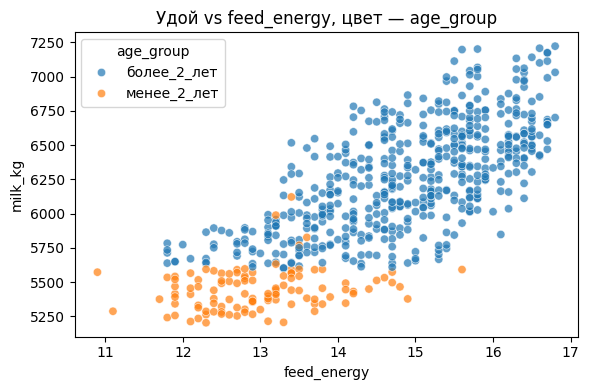

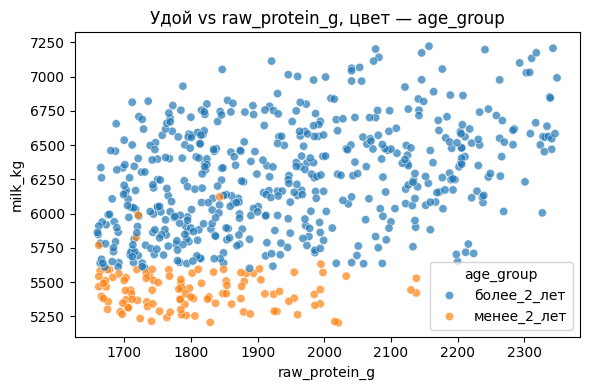

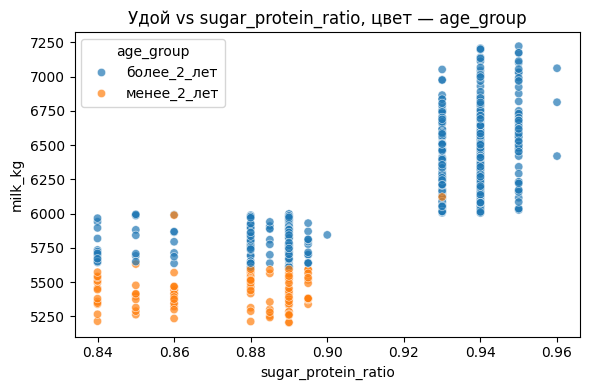

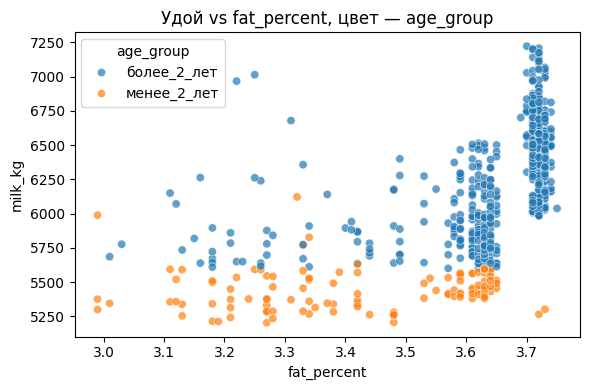

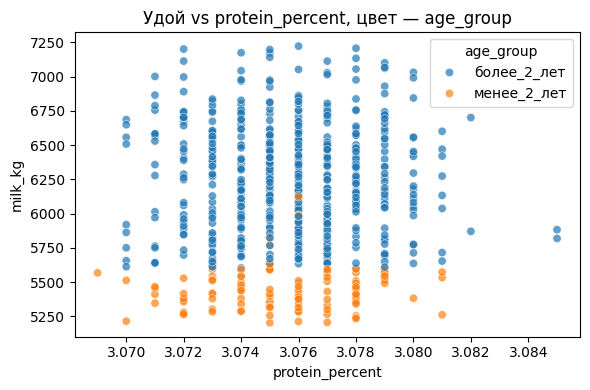

In [50]:
# визуализируем взаимосвязь удоя с другими числовыми признаками с учетом категориального - age_group
for feature in num_cols:
    if feature != 'milk_kg':
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=farm_data, x=feature, y='milk_kg', hue='age_group', alpha=0.7)
        plt.title(f'Удой vs {feature}, цвет — age_group')
        plt.tight_layout()
        plt.show()

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы:</strong>
  <ul> 
    <li><strong>feed_energy:</strong> Наблюдается четкая положительная линейная зависимость с milk_kg (удоем). С увеличением значений feed_enegry удой молока, как правило, возрастает.</li>
    <li><strong>raw_protein_g:</strong> Наблюдается положительная, но более слабая и рассеянная линейная зависимость между raw_protein_g и milk_kg. Признак может быть полезен, но его влияние, возможно, будет менее выраженным.</li> 
    <li><strong>sugar_protein_ratio:</strong> На диаграмме рассеяния показывает нелинейную, скорее кластерную зависимость с milk_kg, подтверждая свое бимодальное распределение. Возможно, его следует преобразовать в категориальный признак (на основе кластеров).</li> 
    <li><strong>fat_percent:</strong> Наблюдается положительная линейная зависимость. По мере увеличения процента жира, удой молока также имеет тенденцию к увеличению. Тем не менее связь с признаком не причинная, показатели самого молока вряд ли будут полезны для модели.</li>
    <li><strong>protein_percent:</strong> Не имеет линейной зависимости с milk_kg на графиках. Признак слабо варьируется и не будет полезен для модели, в том числе из-за отсутствия причинной связи с удоем.</li>  
    <li>Что касается влияния категориальных признаков, то age_group имеет максимальную корреляцию с удоем (старшие коровы дают больше молока), а порода отца-быка (father_breed) является более сильным предиктором удоя. чем порода самой коровы (breed).</li>   
  </ul>
</div>

## Обучение модели линейной регрессии

Заранее напишем функцию для кодирования и масштабирования данных перед обучением:

In [51]:
def prepare_data(cat_col_names, num_col_names, X_train, X_test):
    # кодируем категориальные признаки
    encoder = OneHotEncoder(drop='first', sparse_output=False)

    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_test_ohe = encoder.transform(X_test[cat_col_names])
    encoder_col_names = encoder.get_feature_names_out()

    # масштабируем количественные признаки
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])

    # создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

    # объединяем все преобразованные данные в тренировочный и тестовый датафреймы
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
    
    return X_train, X_test, encoder, scaler

Также напишем функцию для расчета остатков, построения гистограммы их распределения и диаграммы рассеяния:

In [52]:
def get_residuals(y_test, predictions):
    # рассчитаем остатки
    residuals = y_test - predictions

    # построим графики по количественным признакам — гистограмму частотности распределения
    # и диаграмму рассеяния
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].hist(residuals, bins=30)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(predictions, residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()

### Модель №1

**Целевой признак: milk_kg** (удой, кг)

**Признаки, которые стоит исключить:** 
- **id**. Не несет смысловой нагрузки, может ввести модель в заблуждение.
- **protein_percent**. Почти нулевая корреляция с удоем и не только с ним, будет создавать шум. Возможно это стабильный контролируемый показатель с низкой вариативностью. К тому же не имеет причинной связи с удоем.
- **fat_percent**. Как и процент белка, является характеристикой самого молока, не может иметь причинной связи с удоем.
- **milk_taste**. Это субъективная оценка вкуса, а не причина удоя. Не имеет смысла ее использовать в модели.

Другие показатели зависят от кормления, генетики и физиологии — то есть имеют причинную связь с удоем. Также оставляем признак age_group, несмотря на высокую корреляцию с milk_kg, так как это все-таки независимый признак возраста коровы.

In [53]:
# формируем выборки тренировочных и тестовых данных
X = farm_data.drop(['milk_kg', 'id', 'protein_percent', 'fat_percent', 'milk_taste'], axis=1)
y = farm_data['milk_kg']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

# проверим входные данные
X.head()

,feed_energy,raw_protein_g,sugar_protein_ratio,breed,pasture_type,father_breed,age_group
0,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет
1,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет
2,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,более_2_лет
3,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,более_2_лет
4,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет


In [54]:
# списки категориальных и количественных признаков
cat_col_names = ['breed', 'pasture_type', 'father_breed', 'age_group']
num_col_names = ['feed_energy', 'raw_protein_g', 'sugar_protein_ratio']

# кодируем и масштабируем данные с помощью функции prepare_data()
X_train_1, X_test_1, encoder_1, scaler_1 = prepare_data(cat_col_names, num_col_names, X_train, X_test)

In [55]:
# инициализируем модель линейной регрессии
model_lr_1 = LinearRegression()

# обучаем модель на тренировочных данных
# получаем предсказания модели на тестовых данных 
# сохраняем результат в переменную predictions
model_lr_1.fit(X_train_1, y_train)
predictions_1 = model_lr_1.predict(X_test_1)

# считаем метрику r2
r2_1 = r2_score(y_test, predictions_1)
print(f'Метрика R2 первой модели: {r2_1:.5f}')

Метрика R2 первой модели: 0.78441


/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


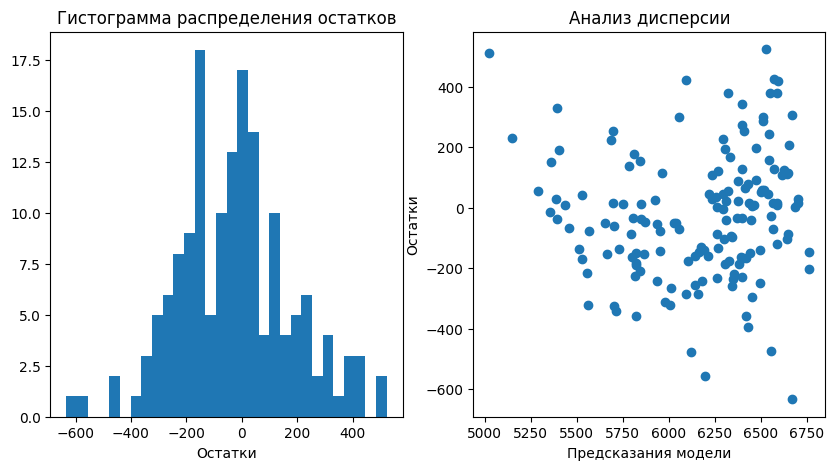

In [56]:
# рассчитаем остатки и
# построим графики по количественным признакам — гистограмму частотности распределения
# и диаграмму рассеяния с помощью функции get_residuals()
get_residuals(y_test, predictions_1)

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы:</strong>
  <ul> 
    <li>R2: 0.784. Это хороший показатель и говорит о том, что модель хорошо улавливает основные закономерности в данных.</li>
    <li>Гистограмма остатков показывает распределение, которое визуально напоминает нормальное распределение, центрированное около нуля. Это является желаемым свойством для линейных моделей, так как указывает на то, что ошибки модели случайны и не имеют явной систематической структуры.</li> 
    <li>Есть небольшие хвосты по обеим сторонам, то есть есть предсказания, которые сильно отклоняются от фактических значений. Стоит обратить на это внимание.</li> 
    <li>На диаграмме рассеяния нет ярко выраженных нелинейных паттернов (например, формы улыбки или подковы), что хорошо и говорит о том, что линейная модель достаточно хорошо улавливает линейные зависимости. Но наблюдается некоторое расширение разброса остатков по мере увеличения предсказаний модели. То есть, при более высоких предсказаниях разброс ошибок становится больше, чем при низких предсказаниях.</li>
    <li>Модель чуть завышает предсказания для низкого удоя. Это нежелательно в рамках бизнес-задачи, ведь фермер не хочет рисковать и хочет покупать только подходящих коров. В любом случае это не так критично, как если бы модель выдавада неподходящих коров за подходящих.</li> 
  </ul>
</div>

### Модель №2

По диаграммам рассеяния можно было заметить, что некоторые входные признаки связаны с целевым нелинейно:
- СПО и удой связаны нелинейно. На их диаграмме рассеяния наблюдения сгруппированы в два кластера, причём есть такое значение СПО, которое можно считать границей между кластерами. Чтобы устранить нелинейность, нужно преобразовать СПО в категориальный бинарный признак, использовав эту границу.
- ЭКЕ и удой также связаны нелинейно. Нелинейность между ними можно исключить, если ввести новый признак ЭКЕ в квадрате.

На этом этапе мы исключим нелинейность, чтобы эти признаки были информативны для линейной регрессии.

In [57]:
# преобразуем СПО (sugar_protein_ratio) в бинарный признак
spo_threshold = 0.91 # граница по графику
farm_data['spo_cluster'] = (farm_data['sugar_protein_ratio'] > spo_threshold).astype(int)

# добавим признак "ЭКЕ в квадрате" (feed_energy_sq)
farm_data['feed_energy_sq'] = farm_data['feed_energy'] ** 2

In [58]:
# формируем выборки тренировочных и тестовых данных
X = farm_data.drop(['milk_kg', 'id', 'protein_percent', 'fat_percent', 'milk_taste', 'sugar_protein_ratio', 'feed_energy'], axis=1)
y = farm_data['milk_kg']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

# проверим входные данные
X.head()

,raw_protein_g,breed,pasture_type,father_breed,age_group,spo_cluster,feed_energy_sq
0,1743,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,0,201.64
1,2138,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,0,163.84
2,1854,РефлешнСоверинг,холмистое,Соверин,более_2_лет,0,196.00
3,2012,РефлешнСоверинг,холмистое,Айдиал,более_2_лет,0,153.76
4,1675,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,0,163.84


In [59]:
# списки категориальных и количественных признаков
cat_col_names = ['breed', 'pasture_type', 'father_breed', 'age_group', 'spo_cluster']
num_col_names = ['feed_energy_sq', 'raw_protein_g']

# кодируем и масштабируем тренировочные данные с помощью функции prepare_data()
X_train_2, X_test_2, encoder_2, scaler_2 = prepare_data(cat_col_names, num_col_names, X_train, X_test)

In [60]:
# инициализируем модель линейной регрессии
model_lr_2  = LinearRegression()

# обучаем модель на тренировочных данных
# получаем предсказания модели на тестовых данных 
# сохраняем результат в переменную predictions
model_lr_2.fit(X_train_2, y_train)
predictions_2 = model_lr_2.predict(X_test_2)

# считаем метрику r2
r2_2 = r2_score(y_test, predictions_2)
print(f'Метрика R2 второй модели: {r2_2:.5f}')

Метрика R2 второй модели: 0.81809


/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


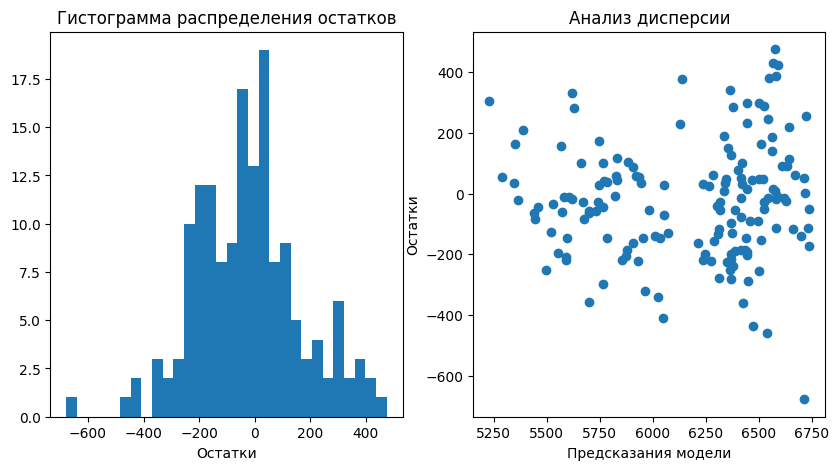

In [61]:
# рассчитаем остатки и
# построим графики по количественным признакам — гистограмму частотности распределения
# и диаграмму рассеяния с помощью функции get_residuals()
get_residuals(y_test, predictions_2)

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы:</strong>
  <ul> 
    <li>Модель теперь объясняет более 81.8% дисперсии удоя (R2), что является очень хорошим показателем. Примененные преобразования признаков (СПО в бинарный, ЭКЕ в квадрате) явно улучшили объясняющую способность модели.</li>
    <li>Пик распределения стал более выраженным и централизованным около нуля. Хвосты распределения, кажется, стали немного менее "тяжелыми", то есть уменьшилось количество очень больших по модулю остатков.</li> 
    <li>На диаграмме рассеяния остаются несколько точек, которые значительно отклоняются от основной массы, но видимых нелинейных паттернов по-прежнему нет, что подтверждает, что линейная модель подходит для улавливания зависимостей.</li> 
    <li>Визуально, общее рассеивание остатков вокруг нуля выглядит немного более сфокусированным в центральной части, что хорошо.</li>
    <li>В целом, вторая модель показывает явный прогресс благодаря преобразованиям признаков.</li>  
  </ul>
</div>

### Модель №3

Проверим, улучшится ли предсказательная способность модели при добавлении новой информации. Добавим новый категориальный признак — father_name, объединив основной датасет farm_data с данными dads_data по идентификатору (id). Это позволит учесть генетическое влияние отца на удой. 

Также есть смысл удалить признак father_breed, так как новый признак father_name уже несет в себе информацию об отце-быке. Это позволит избежать дублирования информации и потенциально может улучшить модель.

In [62]:
# объединяем основной датафрейм с новым по id
farm_data = farm_data.merge(dads_data, on='id', how='left')

# формируем выборки тренировочных и тестовых данных
X = farm_data.drop(['milk_kg', 'id', 'father_breed', 'protein_percent', 'fat_percent', 'milk_taste', 'sugar_protein_ratio', 'feed_energy'], axis=1)
y = farm_data['milk_kg']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

# проверим входные данные
X.head()

,raw_protein_g,breed,pasture_type,age_group,spo_cluster,feed_energy_sq,father_name
0,1743,Вис Бик Айдиал,равнинное,более_2_лет,0,201.64,Буйный
1,2138,Вис Бик Айдиал,равнинное,менее_2_лет,0,163.84,Соловчик
2,1854,РефлешнСоверинг,холмистое,более_2_лет,0,196.00,Барин
3,2012,РефлешнСоверинг,холмистое,более_2_лет,0,153.76,Буйный
4,1675,Вис Бик Айдиал,равнинное,менее_2_лет,0,163.84,Барин


In [63]:
# списки категориальных и количественных признаков
cat_col_names = ['breed', 'pasture_type', 'age_group', 'spo_cluster', 'father_name']
num_col_names = ['feed_energy_sq', 'raw_protein_g']

# кодируем и масштабируем данные с помощью функции prepare_data()
X_train_3, X_test_3, encoder_3, scaler_3 = prepare_data(cat_col_names, num_col_names, X_train, X_test)

In [64]:
# инициализируем модель линейной регрессии
model_lr_3  = LinearRegression()

# обучаем модель на тренировочных данных
# получаем предсказания модели на тестовых данных 
# сохраняем результат в переменную predictions
model_lr_3.fit(X_train_3, y_train)
predictions_3 = model_lr_3.predict(X_test_3)

# считаем метрику r2
r2_3 = r2_score(y_test, predictions_3)
print(f'Метрика R2 третьей модели: {r2_3:.5f}')

Метрика R2 третьей модели: 0.82651


/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


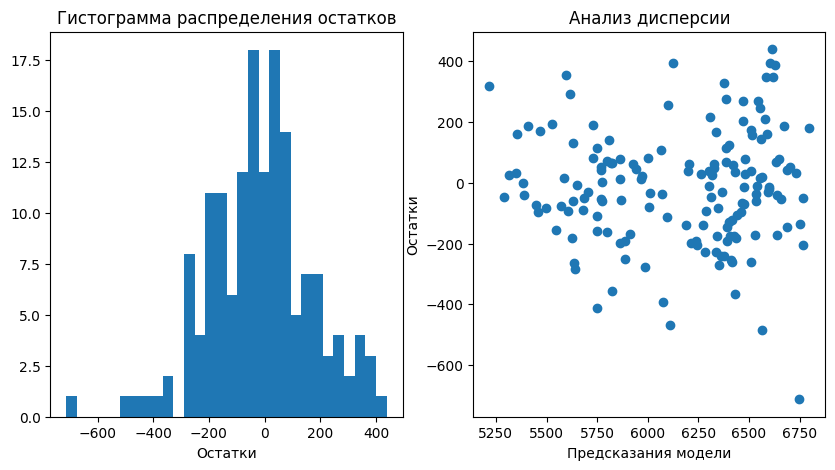

In [65]:
# рассчитаем остатки и
# построим графики по количественным признакам — гистограмму частотности распределения
# и диаграмму рассеяния с помощью функции get_residuals()
get_residuals(y_test, predictions_3)

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы:</strong>
  <ul> 
    <li>Модель теперь объясняет более 82.6% дисперсии удоя (R2). Это подтверждает, что добавление признака father_name принесло дополнительную, хоть и небольшую, предсказательную силу.</li>
    <li>Пик гистограммы стал еще более узким и высоким, что означает, что модель теперь чаще делает очень маленькие ошибки. Это желаемый результат. Хвосты распределения тоже стали менее выраженными.</li> 
    <li>На диаграмме рассеяния заметны небольшие положительные изменения по сравнению с предыдущими графиками.</li> 
    <li>Третья модель показывает лучший R2, что означает, что она объясняет наибольшую долю дисперсии удоя среди всех рассмотренных моделей. Это же видно по графикам.</li>
    <li>Последовательные шаги по улучшению модели, включая учет нелинейностей и добавление генетических факторов (father_name), привели к заметному и стабильному улучшению качества регрессионной модели. Эта версия является наиболее надежной и точной для предсказания удоя.</li>  
  </ul>
</div>

### Сравнение моделей

Дополнительно оценим качество каждой модели по трём метрикам: MSE, RMSE, MAE.

Что означают метрики:

- MSE (среднеквадратичная ошибка) — чувствительна к выбросам (ошибка возводится в квадрат).

- RMSE (корень из MSE) — тоже чувствителен к выбросам, но в тех же единицах, что и предсказание.

- MAE (средняя абсолютная ошибка) — средняя ошибка в тех же единицах, что и целевой признак. Хорошо отражает среднее отклонение.

In [66]:
# расчитываем метрики и выводим в виде таблицы
results_df = pd.DataFrame(columns=['Модель 1', 'Модель 2', 'Модель 3'], index=['R2', 'MSE', 'RMSE', 'MAE'])

results_df['Модель 1'] = [
    r2_1,
    mean_squared_error(y_test, predictions_1),
    mean_squared_error(y_test, predictions_1)**0.5,
    mean_absolute_error(y_test, predictions_1)
]
results_df['Модель 2'] = [
    r2_2,
    mean_squared_error(y_test, predictions_2),
    mean_squared_error(y_test, predictions_2)**0.5,
    mean_absolute_error(y_test, predictions_2)
]
results_df['Модель 3'] = [
    r2_3,
    mean_squared_error(y_test, predictions_3),
    mean_squared_error(y_test, predictions_3)**0.5,
    mean_absolute_error(y_test, predictions_3)
]

results_df

,Модель 1,Модель 2,Модель 3
R2,0.784408,0.818088,0.826512
MSE,43887.015010,37030.911311,35316.004360
RMSE,209.492279,192.434174,187.925529
MAE,164.241945,149.039652,144.638137


Также рассчитаем доверительный интервал прогноза лучшей модели (Модель №3):

In [67]:
print(f'С вероятностью 95% удой будет находиться в интервале \
от {round(np.quantile(predictions_3, .025))} кг до {round(np.quantile(predictions_3, .975))} кг.')

С вероятностью 95% удой будет находиться в интервале от 5354 кг до 6748 кг.


<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы:</strong>
  <ul> 
    <li>Каждая последующая версия модели объясняет большую долю дисперсии удоя (R2), что указывает на улучшение общей объясняющей способности модели. Модель №3 является лучшей в этом отношении, объясняя более 82.6% вариации удоя.</li>
    <li>MSE последовательно уменьшается от Модели №1 к Модели №3 (43887.02 -> 37030.91 -> 35316). Это означает, что средний квадрат ошибки модели уменьшается, следовательно, модель становится более точной в своих предсказаниях. Меньшее значение MSE всегда лучше.</li> 
    <li>RMSE также последовательно уменьшается (209.49 -> 192.43 -> 187.93). RMSE измеряет среднюю величину ошибок предсказаний в тех же единицах, что и целевая переменная (килограммы молока). Уменьшение RMSE указывает на то, что модель в среднем делает меньшие ошибки при предсказании удоя.</li> 
    <li>MAE также последовательно уменьшается (164.24 -> 149.04 -> 144.64). MAE измеряет среднюю абсолютную величину ошибок и менее чувствительна к выбросам. Уменьшение MAE означает, что модель в среднем делает меньшие ошибки без учета их направления.</li>
    <li>В случае модели №3 с вероятностью 95% удой будет находиться в интервале от 5354 кг до 6748 кг.</li>   
    <li>Для задачи прогнозирования удоя следует использовать Модель №3. Она демонстрирует наилучшие показатели по всем ключевым метрикам качества.</li>  
  </ul>
</div>

### Итоговый прогноз

С помощью лучшей модели (Модель №3) спрогнозируем удой коров, которых фермер хочет купить. Данные о них находятся в датафрейме ecofarm_data:

In [68]:
# создаем копию датафрейма
ecofarm_ml = ecofarm_data.copy(deep=True)

# добавляем новые признаки в ecofarm_data
ecofarm_ml['feed_energy_sq'] = (farm_data['feed_energy'].mean() * 1.05) ** 2 # квадрат ЭКЕ
ecofarm_ml['raw_protein_g'] = farm_data['raw_protein_g'].mean() * 1.05
ecofarm_ml['spo_cluster'] = ((farm_data['sugar_protein_ratio'].mean() * 1.05) > spo_threshold).astype(int) # бинарный признак СПО

# удалим лишние признаки 
ecofarm_ml = ecofarm_ml.drop(['protein_percent', 'fat_percent', 'father_breed'], axis=1)

# проверяем содержание датафрейма перед моделированием
display(ecofarm_ml.shape)
display(ecofarm_ml.head())

(20, 7)

,breed,pasture_type,father_name,age_group,feed_energy_sq,raw_protein_g,spo_cluster
0,Вис Бик Айдиал,холмистое,Геркулес,более_2_лет,233.361138,2019.947532,1
1,Вис Бик Айдиал,равнинное,Буйный,менее_2_лет,233.361138,2019.947532,1
2,РефлешнСоверинг,равнинное,Барин,более_2_лет,233.361138,2019.947532,1
3,РефлешнСоверинг,холмистое,Буйный,более_2_лет,233.361138,2019.947532,1
4,РефлешнСоверинг,равнинное,Буйный,более_2_лет,233.361138,2019.947532,1


In [70]:
# списки категориальных и количественных признаков
cat_col_names = ['breed', 'pasture_type', 'age_group', 'spo_cluster', 'father_name']
num_col_names = ['feed_energy_sq', 'raw_protein_g']

# кодируем категориальные признаки
X_test_ohe = encoder_3.transform(ecofarm_ml[cat_col_names])
encoder_col_names = encoder_3.get_feature_names_out()

# масштабируем количественные признаки
X_test_scaled = scaler_3.transform(ecofarm_ml[num_col_names])

# создаём датафреймы с индексами
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names, index=ecofarm_ml.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names, index=ecofarm_ml.index)

# объединяем данные
X_test_full = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [71]:
# делаем финальное предсказание
final_predictions = model_lr_3.predict(X_test_full)

# сохраняем предсказания
ecofarm_ml['predicted_milk_kg'] = final_predictions

# выводим результат
ecofarm_ml.head(25)

,breed,pasture_type,father_name,age_group,feed_energy_sq,raw_protein_g,spo_cluster,predicted_milk_kg
0,Вис Бик Айдиал,холмистое,Геркулес,более_2_лет,233.361138,2019.947532,1,6608.443615
1,Вис Бик Айдиал,равнинное,Буйный,менее_2_лет,233.361138,2019.947532,1,6334.275064
2,РефлешнСоверинг,равнинное,Барин,более_2_лет,233.361138,2019.947532,1,6281.140194
3,РефлешнСоверинг,холмистое,Буйный,более_2_лет,233.361138,2019.947532,1,6592.027874
4,РефлешнСоверинг,равнинное,Буйный,более_2_лет,233.361138,2019.947532,1,6543.028775
5,РефлешнСоверинг,равнинное,Геркулес,менее_2_лет,233.361138,2019.947532,1,6380.167370
6,Вис Бик Айдиал,холмистое,Геркулес,более_2_лет,233.361138,2019.947532,1,6608.443615
7,Вис Бик Айдиал,равнинное,Буйный,более_2_лет,233.361138,2019.947532,1,6528.290493
8,РефлешнСоверинг,равнинное,Барин,более_2_лет,233.361138,2019.947532,1,6281.140194
9,РефлешнСоверинг,холмистое,Буйный,менее_2_лет,233.361138,2019.947532,1,6398.012445


Диапазон предсказаний (от 6121 кг до 6608 кг) указывает на то, что модель прогнозирует не просто достаточный удой, а достаточно высокую и стабильную продуктивность для всех анализируемых коров. Даже минимальное предсказанное значение (6121 кг) комфортно превышает требуемый порог.

## Обучение модели логистической регрессии

Теперь, когда у нас есть надёжный прогноз по удою, следующим критически важным шагом является определение, будет ли молоко вкусным.

На этом этапе мы разработаем вторую модель машинного обучения — логистическую регрессию, которая будет предсказывать вероятность того, что молоко от конкретной коровы будет вкусным. Это позволит нам классифицировать коров по признаку "вкус молока" и выбрать тех, кто соответствует второму ключевому условию закупки.

### Обучение модели

In [72]:
# копируем основной датафрейм
farm_log = farm_data.copy(deep=True)

# адаптируем целевой признак 
farm_log['milk_taste'] = farm_log['milk_taste'].apply(lambda x: 1 if x == 'вкусно' else 0)

In [73]:
# отбираем признаки
X = farm_log.drop(['id', 'milk_kg', 'milk_taste', 'father_breed', 'feed_energy', 'sugar_protein_ratio', 'protein_percent'], axis=1)
y = farm_log['milk_taste']

# разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    stratify=y
)

# проверим входные данные
X.head()

,raw_protein_g,breed,pasture_type,fat_percent,age_group,spo_cluster,feed_energy_sq,father_name
0,1743,Вис Бик Айдиал,равнинное,3.58,более_2_лет,0,201.64,Буйный
1,2138,Вис Бик Айдиал,равнинное,3.54,менее_2_лет,0,163.84,Соловчик
2,1854,РефлешнСоверинг,холмистое,3.59,более_2_лет,0,196.00,Барин
3,2012,РефлешнСоверинг,холмистое,3.40,более_2_лет,0,153.76,Буйный
4,1675,Вис Бик Айдиал,равнинное,3.73,менее_2_лет,0,163.84,Барин


In [76]:
# категориальные и количественные признаки
cat_cols = ['breed', 'pasture_type', 'father_name', 'age_group', 'spo_cluster']
num_cols = ['fat_percent', 'feed_energy_sq', 'raw_protein_g']

# кодирование
encoder_log = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder_log.fit_transform(X_train[cat_cols])
X_test_ohe = encoder_log.transform(X_test[cat_cols])
encoder_col_names = encoder_log.get_feature_names_out()

# масштабирование
scaler_log = StandardScaler()
X_train_scaled = scaler_log.fit_transform(X_train[num_cols])
X_test_scaled = scaler_log.transform(X_test[num_cols])

# датафреймы с индексами
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names, index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names, index=X_test.index)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols, index=X_test.index)

# объединение
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [77]:
# обучение модели
model_clf = LogisticRegression(random_state=RANDOM_STATE)
model_clf.fit(X_train, y_train)
y_pred = model_clf.predict(X_test)

# считаем метрики accuracy, recall, precision  
clf_accuracy = accuracy_score(y_test, y_pred)
clf_recall = recall_score(y_test, y_pred)
clf_precision = precision_score(y_test, y_pred)

print(f'Accuracy: {clf_accuracy:.3f}')
print(f'Recall: {clf_recall:.3f}')
print(f'Precision: {clf_precision:.3f}')

Accuracy: 0.580
Recall: 0.717
Precision: 0.623


/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise 

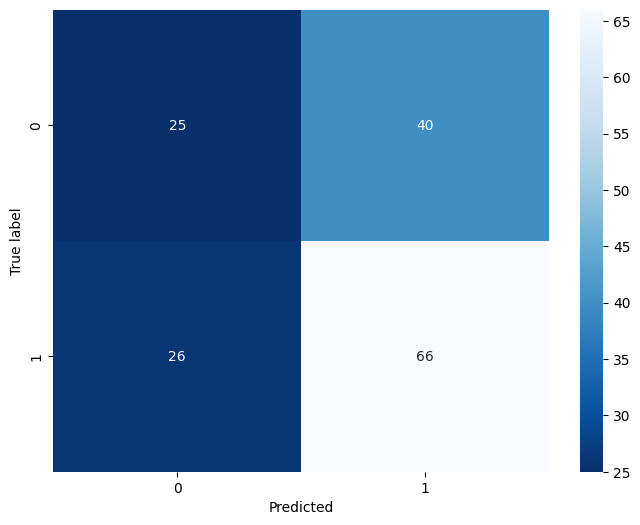

In [78]:
# строим матрицу ошибок 
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

Расшифровка матрицы ошибок (где 0 - "невкусно", 1 - "вкусно"):
- TN (True Negatives): 25 - количество образцов "невкусного" молока, которые модель правильно предсказала как "невкусные".
- FP (False Positives): 40 - количество образцов "невкусного" молока, которые модель ошибочно предсказала как "вкусные" (ложно-положительные предсказания).
- FN (False Negatives): 26 - количество образцов "вкусного" молока, которые модель ошибочно предсказала как "невкусные" (пропуски).
- TP (True Positives): 66 - количество образцов "вкусного" молока, которые модель правильно предсказала как "вкусные".

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы:</strong>
  <ul> 
    <li><strong>Accuracy: 0.58</strong>. Общая точность модели составляет около 58%. Это не очень высокий показатель. Это означает, что модель правильно классифицирует чуть более половины образцов (чуть лучше случайного предсказания). Для большинства задач классификации хотелось бы видеть точность выше, особенно если классы сбалансированы.</li>
    <li><strong>Recall: 0.717</strong>. Recall показывает, какую долю всех настоящих положительных объектов модель правильно нашла. Это хороший показатель полноты, который минимизирует пропуск "хороших" коров.</li> 
    <li><strong>Precision: 0.623</strong>. Precision показывает, какая доля объектов, предсказанных моделью как положительные, действительно положительны. Если модель предсказывает, что молоко "вкусное", в 62.3% случаев это предсказание будет правильным. Это означает, что почти 37.7% предсказаний "вкусного" молока будут ложноположительными. Для фермера это может означать, что среди закупленных по рекомендации модели коров, часть будет давать "невкусное" молоко, что является нежелательным риском.</li> 
  </ul>
</div>

Учитывая бизнес-задачу (минимизировать риск покупки коровы с "невкусным" молоком), ошибка первого рода, то есть покупка коровы с "невкусным" молоком, критичнее всего. Для минимизации этой ошибки необходимо улучшить метрику Precision, чего можно добиться, повысив порог классификации на основе анализа Precision-Recall кривой:

/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


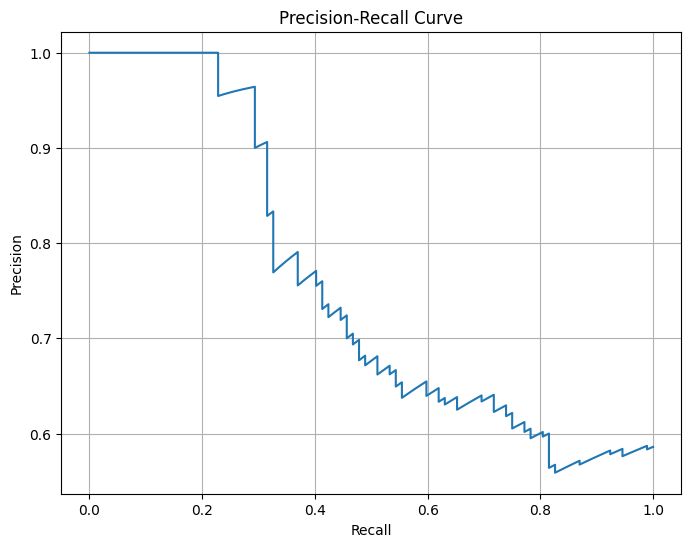

In [79]:
# предсказываем вероятности
y_probs = model_clf.predict_proba(X_test)[:, 1]   

# строим Precision-Recall кривую
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [80]:
# выбираем более детальный диапазон порогов
thresholds = np.arange(0.6, 0.91, 0.01)

# cохраняем результаты
thresh_results = []

# перебираем пороги и результаты для них
for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh, zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    
    thresh_results.append({
        'Threshold': round(thresh, 2),
        'Accuracy': round(accuracy, 3),
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn
    })

# выводим таблицу
thresh_results_df = pd.DataFrame(thresh_results)
thresh_results_df

,Threshold,Accuracy,Precision,Recall,TP,FP,FN,TN
0,0.60,0.573,0.651,0.587,54,29,38,36
1,0.61,0.567,0.658,0.543,50,26,42,39
2,0.62,0.567,0.662,0.533,49,25,43,40
3,0.63,0.567,0.671,0.511,47,23,45,42
4,0.64,0.567,0.682,0.489,45,21,47,44
5,0.65,0.573,0.705,0.467,43,18,49,47
6,0.66,0.573,0.727,0.435,40,15,52,50
7,0.67,0.567,0.731,0.413,38,14,54,51
8,0.68,0.580,0.760,0.413,38,12,54,53
9,0.69,0.580,0.771,0.402,37,11,55,54


Дана задача свести критичную ошибку к нулю. Мы определили, что критичная ошибка для фермера — это False Positive (FP), а значит нужно стремиться найти такой порог, при котором количество False Positives будет равно нулю. По графику и детализированной таблице выше FP равно нулю при пороге классификации - 0.79.

Стремление к FP равному нулю практически всегда приводит к очень сильному снижению Recall (что видно по графику и таблице метрик). Это означает, что мы будем пропускать множество истинно "вкусных" коров, классифицируя их как "невкусные", просто чтобы быть абсолютно уверенными в тех немногих, которых классифицируем как "вкусных".

Еще раз посмотрим на показатели при пороге 0.79:

In [81]:
# новый порог классификации
threshold = 0.79
y_pred_new = (y_probs >= threshold).astype(int)

# считаем метрики accuracy, recall, precision c новым порогом
clf_accuracy = accuracy_score(y_test, y_pred_new)
clf_recall = recall_score(y_test, y_pred_new)
clf_precision = precision_score(y_test, y_pred_new)

print(f'Accuracy: {clf_accuracy:.3f}')
print(f'Recall: {clf_recall:.3f}')
print(f'Precision: {clf_precision:.3f}')

Accuracy: 0.535
Recall: 0.207
Precision: 1.000


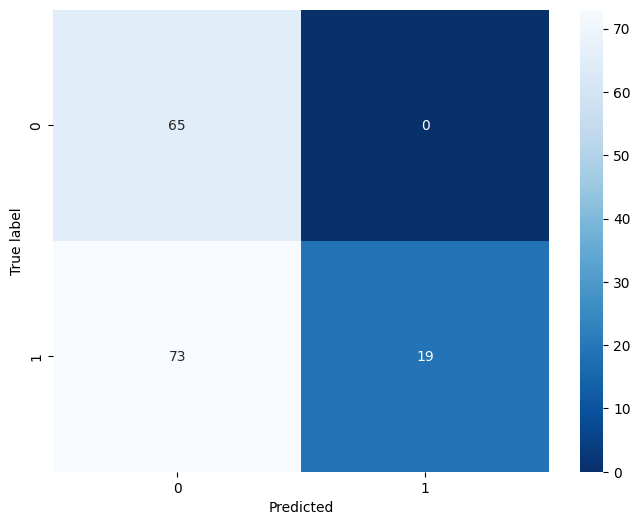

In [82]:
# строим новую матрицу ошибок 
cm = confusion_matrix(y_test, y_pred_new)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

Все-таки оптимальным вариантом кажется порог на отметке 0.69 - в этом случае достигается лучший баланс между метриками (accuracy: 0.58, precision: 0.77, recall: 0.4) и достачно высокий показатель Precision, позволяющий снизить риски, но не свети их к нулю (при этом сохраняя некоторую полноту).

Не будем отходить от поставленной задачи и попробуем соблюсти строгие требования заказчика, установив соответствующий порог классификации - 0.79. Проверим результат такого подхода на данных "ЭкоФермы". В качестве альтернативного варианта, но с бОльшими рисками, проведем расчеты и для порога 0.69.

### Итоговый прогноз

Требование свести критичную ошибку к нулю выполнимо, но результат скорее всего будет следующим:

- Высочайшее качество: каждая купленная корова гарантированно будет давать вкусное молоко.
- Очень низкий объём закупки: количество коров, которые модель порекомендует к покупке, будет очень малым, возможно, недостаточным для плана расширения хозяйства.

Проверим это на практике:

In [83]:
# создаем копию датафрейма
ecofarm_log = ecofarm_data.copy(deep=True)

# добавляем новые признаки в ecofarm_data
ecofarm_log['feed_energy_sq'] = (farm_data['feed_energy'].mean() * 1.05) ** 2 # квадрат ЭКЕ
ecofarm_log['raw_protein_g'] = farm_data['raw_protein_g'].mean() * 1.05
ecofarm_log['spo_cluster'] = ((farm_data['sugar_protein_ratio'].mean() * 1.05) > spo_threshold).astype(int) # бинарный признак СПО

# удалим лишние признаки 
ecofarm_log = ecofarm_log.drop(['protein_percent', 'father_breed'], axis=1)

# проверяем содержание датафрейма перед моделированием
display(ecofarm_log.shape)
display(ecofarm_log.head())

(20, 8)

,breed,pasture_type,father_name,fat_percent,age_group,feed_energy_sq,raw_protein_g,spo_cluster
0,Вис Бик Айдиал,холмистое,Геркулес,3.58,более_2_лет,233.361138,2019.947532,1
1,Вис Бик Айдиал,равнинное,Буйный,3.54,менее_2_лет,233.361138,2019.947532,1
2,РефлешнСоверинг,равнинное,Барин,3.59,более_2_лет,233.361138,2019.947532,1
3,РефлешнСоверинг,холмистое,Буйный,3.40,более_2_лет,233.361138,2019.947532,1
4,РефлешнСоверинг,равнинное,Буйный,3.64,более_2_лет,233.361138,2019.947532,1


In [84]:
# категориальные и количественные признаки
cat_cols = ['breed', 'pasture_type', 'father_name', 'age_group', 'spo_cluster']
num_cols = ['fat_percent', 'feed_energy_sq', 'raw_protein_g']

# кодирование
X_test_ohe = encoder_log.transform(ecofarm_log[cat_cols])
encoder_col_names = encoder_log.get_feature_names_out()

# масштабирование
X_test_scaled = scaler_log.transform(ecofarm_log[num_cols])

# датафреймы с индексами
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names, index=ecofarm_log.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols, index=ecofarm_log.index)

# объединение
X_test_log = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [85]:
# применяем модель
final_probs = model_clf.predict_proba(X_test_log)[:, 1]

# строгий порог классификации
strict_threshold = 0.79
final_predictions = (final_probs > strict_threshold).astype(int)

# выведем результат
ecofarm_log['str_predicted_taste'] = final_predictions
ecofarm_log['str_predicted_taste'] = ecofarm_log['str_predicted_taste'].apply(lambda x: 'вкусно' if x == 1 else 'не вкусно')

ecofarm_log.head(20)

,breed,pasture_type,father_name,fat_percent,age_group,feed_energy_sq,raw_protein_g,spo_cluster,str_predicted_taste
0,Вис Бик Айдиал,холмистое,Геркулес,3.58,более_2_лет,233.361138,2019.947532,1,не вкусно
1,Вис Бик Айдиал,равнинное,Буйный,3.54,менее_2_лет,233.361138,2019.947532,1,не вкусно
2,РефлешнСоверинг,равнинное,Барин,3.59,более_2_лет,233.361138,2019.947532,1,не вкусно
3,РефлешнСоверинг,холмистое,Буйный,3.40,более_2_лет,233.361138,2019.947532,1,не вкусно
4,РефлешнСоверинг,равнинное,Буйный,3.64,более_2_лет,233.361138,2019.947532,1,не вкусно
5,РефлешнСоверинг,равнинное,Геркулес,3.63,менее_2_лет,233.361138,2019.947532,1,не вкусно
6,Вис Бик Айдиал,холмистое,Геркулес,3.58,более_2_лет,233.361138,2019.947532,1,не вкусно
7,Вис Бик Айдиал,равнинное,Буйный,3.57,более_2_лет,233.361138,2019.947532,1,не вкусно
8,РефлешнСоверинг,равнинное,Барин,3.59,более_2_лет,233.361138,2019.947532,1,не вкусно
9,РефлешнСоверинг,холмистое,Буйный,3.40,менее_2_лет,233.361138,2019.947532,1,не вкусно


Результат предсказуем. Требование FP = 0 — это крайне строгий критерий, который часто сильно ограничивает количество положительных предсказаний. В случае с "ЭкоФермой" их нет.

Проверим, какой результат будет при пороге классификации 0.69:

In [86]:
# оптимальный порог классификации
optimal_threshold = 0.69

optimal_predictions = (final_probs > optimal_threshold).astype(int)

# выведем результат
ecofarm_log['opt_predicted_taste'] = optimal_predictions
ecofarm_log['opt_predicted_taste'] = ecofarm_log['opt_predicted_taste'].apply(lambda x: 'вкусно' if x == 1 else 'не вкусно')

ecofarm_log.head(20)

,breed,pasture_type,father_name,fat_percent,age_group,feed_energy_sq,raw_protein_g,spo_cluster,str_predicted_taste,opt_predicted_taste
0,Вис Бик Айдиал,холмистое,Геркулес,3.58,более_2_лет,233.361138,2019.947532,1,не вкусно,не вкусно
1,Вис Бик Айдиал,равнинное,Буйный,3.54,менее_2_лет,233.361138,2019.947532,1,не вкусно,не вкусно
2,РефлешнСоверинг,равнинное,Барин,3.59,более_2_лет,233.361138,2019.947532,1,не вкусно,не вкусно
3,РефлешнСоверинг,холмистое,Буйный,3.40,более_2_лет,233.361138,2019.947532,1,не вкусно,вкусно
4,РефлешнСоверинг,равнинное,Буйный,3.64,более_2_лет,233.361138,2019.947532,1,не вкусно,не вкусно
5,РефлешнСоверинг,равнинное,Геркулес,3.63,менее_2_лет,233.361138,2019.947532,1,не вкусно,не вкусно
6,Вис Бик Айдиал,холмистое,Геркулес,3.58,более_2_лет,233.361138,2019.947532,1,не вкусно,не вкусно
7,Вис Бик Айдиал,равнинное,Буйный,3.57,более_2_лет,233.361138,2019.947532,1,не вкусно,не вкусно
8,РефлешнСоверинг,равнинное,Барин,3.59,более_2_лет,233.361138,2019.947532,1,не вкусно,не вкусно
9,РефлешнСоверинг,холмистое,Буйный,3.40,менее_2_лет,233.361138,2019.947532,1,не вкусно,вкусно


Как мы видим, результат в этом случае ощутимо лучше - модель смогла отобрать 4 коровы с потенциально вкусным молоком. Порог 0.69 обеспечивает высокую, но не абсолютную, уверенность (Precision: 77.1%), что молоко будет вкусным. Это означает, что примерно 2-3 из 10 купленных коров могут дать невкусное молоко. Однако при этом пороге можно приобрести значительно больше коров, соответствующих критериям удоя и вкуса.

## Финальный отбор на основе предсказаний

Проверим коров "ЭкоФермы" на соответствие критериям (удой от 6000 кг/год, молоко должно быть "вкусным"):

In [87]:
# соберем предсказания в один датафрейм
cows_to_buy = ecofarm_log.copy(deep=True)
cows_to_buy['predicted_milk_kg'] = ecofarm_ml['predicted_milk_kg']

# проверим наличие ключевых признаков
cows_to_buy.head(20)

,breed,pasture_type,father_name,fat_percent,age_group,feed_energy_sq,raw_protein_g,spo_cluster,str_predicted_taste,opt_predicted_taste,predicted_milk_kg
0,Вис Бик Айдиал,холмистое,Геркулес,3.58,более_2_лет,233.361138,2019.947532,1,не вкусно,не вкусно,6608.443615
1,Вис Бик Айдиал,равнинное,Буйный,3.54,менее_2_лет,233.361138,2019.947532,1,не вкусно,не вкусно,6334.275064
2,РефлешнСоверинг,равнинное,Барин,3.59,более_2_лет,233.361138,2019.947532,1,не вкусно,не вкусно,6281.140194
3,РефлешнСоверинг,холмистое,Буйный,3.40,более_2_лет,233.361138,2019.947532,1,не вкусно,вкусно,6592.027874
4,РефлешнСоверинг,равнинное,Буйный,3.64,более_2_лет,233.361138,2019.947532,1,не вкусно,не вкусно,6543.028775
5,РефлешнСоверинг,равнинное,Геркулес,3.63,менее_2_лет,233.361138,2019.947532,1,не вкусно,не вкусно,6380.167370
6,Вис Бик Айдиал,холмистое,Геркулес,3.58,более_2_лет,233.361138,2019.947532,1,не вкусно,не вкусно,6608.443615
7,Вис Бик Айдиал,равнинное,Буйный,3.57,более_2_лет,233.361138,2019.947532,1,не вкусно,не вкусно,6528.290493
8,РефлешнСоверинг,равнинное,Барин,3.59,более_2_лет,233.361138,2019.947532,1,не вкусно,не вкусно,6281.140194
9,РефлешнСоверинг,холмистое,Буйный,3.40,менее_2_лет,233.361138,2019.947532,1,не вкусно,вкусно,6398.012445


### Результат при строгом соблюдении требований:

In [88]:
# отберем только тех коров, которые подходят под строгие критерии
cows_to_buy_1 = cows_to_buy[(cows_to_buy['str_predicted_taste'] == 'вкусно') & (cows_to_buy['predicted_milk_kg'] >= 6000)]

# выведем результат
cows_to_buy_1

,breed,pasture_type,father_name,fat_percent,age_group,feed_energy_sq,raw_protein_g,spo_cluster,str_predicted_taste,opt_predicted_taste,predicted_milk_kg


К сожалению, ни одна из коров "ЭкоФермы" не удовлетворяет изначальным требованиям заказчика, а именно:
- имеет удой более 6000 кг молока в год;
- имеет "вкусное" молоко (согласно строгому порогу классификации 0.79).

### Результат при подборе оптимальных критериев:

In [89]:
# отберем только тех коров, которые подходят под оптимальные критерии
cows_to_buy_2 = cows_to_buy[(cows_to_buy['opt_predicted_taste'] == 'вкусно') & (cows_to_buy['predicted_milk_kg'] >= 6000)]

# выведем результат
cows_to_buy_2

,breed,pasture_type,father_name,fat_percent,age_group,feed_energy_sq,raw_protein_g,spo_cluster,str_predicted_taste,opt_predicted_taste,predicted_milk_kg
3,РефлешнСоверинг,холмистое,Буйный,3.40,более_2_лет,233.361138,2019.947532,1,не вкусно,вкусно,6592.027874
9,РефлешнСоверинг,холмистое,Буйный,3.40,менее_2_лет,233.361138,2019.947532,1,не вкусно,вкусно,6398.012445
13,Вис Бик Айдиал,холмистое,Барин,3.42,менее_2_лет,233.361138,2019.947532,1,не вкусно,вкусно,6121.385582
15,РефлешнСоверинг,холмистое,Буйный,3.40,более_2_лет,233.361138,2019.947532,1,не вкусно,вкусно,6592.027874


При пороге классификации 0.69 "ЭкоФерма" может предложит 4 потенциально подходящих коровы. Это означает, что можно купить 4 коровы, принимая на себя управляемый риск, что 2-3 из 10 (теоретически) могут не соответствовать строгим критериям вкуса.

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы:</strong>
  <ul> 
    <li>Все потенциальные коровы из стада «ЭкоФермы» соответствуют первому критерию по удою, предсказывая от 6121 кг до 6608 кг молока в год. Это означает, что по удою все коровы удовлетворяют требованию.</li>
    <li>Исходя из строгих требований по качеству молока (порог классификации 0.79), фермер не может купить ни одной коровы из текущего стада «ЭкоФермы» с минимальным риском, который сводится к нулю ошибок первого рода (покупка коровы с "невкусным" молоком).</li> 
    <li>Снижение порога до 0.69 имеет смысл и годится как компромисс, если фермер готов принять тот факт, что примерно 23% рекомендованных коров могут дать невкусное молоко. 4 коровы "ЭкоФермы" в этом случае подойдут для покупки.</li>   
    <li>Выбор между этими порогами зависит от готовности к риску и планов по объему закупки. Если важнее получить большее количество потенциальных коров, даже с небольшим риском, то порог 0.69 будет оптимальным выбором. Если же абсолютная гарантия качества молока важнее всего, то тогда следует выбрать порог 0.79, но в этом случае количество закупаемых коров будет минимальным (в "ЭкоФерме" нет коров, подходящих под строгие критерии).</li>
  </ul>
</div>

## Итоговые выводы

### Предобработка данных

- Изменены названия столбцов в датасетах;
- Явные дубликаты устранены там, где это необходимо;
- Устранены неявные дубликаты в категориальных столбцах; 
- Пропуски в данных отсутствовали;
- Типы данных корректны;
- Для удобного анализа данных объединены данные об имеющемся стаде (датафреймы farm_data и dads_data) в новый датафрейм - farm_total.  

Этот этап позволил очистить данные и подготовить их к дальнейшему анализу.

### Исследовательский анализ данных

Основные выводы исследовательского анализа данных для дальнейшей работы:

- Были проанализированы распределения признаков, также данные проверены на наличие выбросов.
- Критический выброс в удое (milk_kg) был обнаружен и удалён для обеспечения точности моделей.
- Подтверждено наличие потенциально важных факторов: показатели корма (feed_energy, raw_protein_g), порода коров (breed), тип пастбища (pasture_type), возраст (age_group), генетика (father_breed, father_name).
- Признаки в ecofarm_data, на которых будут строится итоговые предсказания, имеют схожие диапазоны значений, что способствует применимости моделей.

Данные подготовлены для корреляционного анализа.

### Корреляционный анализ

Основные выводы корреляционного анализа данных для дальнейшей работы:

- Построена матрица корреляции по коэффициенту Phi, которая используется для анализа категориальных признаков, а также пар числовых-категориальных признаков.
- Построены диаграммы рассеяния для исследования характера корреляций.
- Были определены взаимосвязи между целевым и входными признаками, в том числе нелинейные.
- Выявлены наиболее полезные для моделей признаки, а также те, которые следует исключить при моделировании.
- Входные признаки проверены на наличие мультиколлинеарности. Она отсутствует.

Данные подготовлены для построения двух прогнозных моделей (удоя и вкуса молока) с учётом выявленных характеристик и взаимосвязей.

### Модель линейной регрессии

Основные выводы построения модели линейной регрессии для прогнозирования удоя:

**Последовательное улучшение качества:** 
- Каждая последующая версия модели (всего их было 3) демонстрировала устойчивое улучшение по всем ключевым метрикам.
- Коэффициент детерминации (R2) стабильно рос, указывая на повышение объясняющей способности модели.
- Одновременно метрики ошибок (MSE, RMSE, MAE) последовательно снижались, подтверждая увеличение точности предсказаний.

**Выбор оптимальной модели:** 
- Модель №3 была выбрана как наилучшая для прогнозирования удоя, поскольку она показала наивысший R2 (более 82% объясненной дисперсии) и наименьшие ошибки, что свидетельствует о её максимальной точности и объясняющей силе среди разработанных версий.

**Успешность предсказаний для бизнес-задачи:** 
- На данных для финального предсказания Модель №3 показала диапазон удоя от 6121 кг до 6608 кг.
- Все предсказанные значения комфортно превышают требуемый фермером порог в 6000 кг/год, что указывает на то, что все анализируемые коровы потенциально соответствуют критерию минимальной продуктивности.

### Модель логистической регрессии

Основные выводы построения модели логистической регрессии для прогнозирования вкуса молока:

**Идентификация критической ошибки:**
- Определено, что для заказчика критической является ошибка первого рода (False Positive) – покупка коровы с невкусным молоком. 
- Цель моделирования — минимизировать эту ошибку.

**Компромисс между Precision и Recall:**
- При стремлении к нулевому FP (порог 0.79), Precision достигает 1.0, что соответствует строгим требованиям заказчика по отсутствию риска. Но при этом подходе ни одна корова из стада «ЭкоФермы» не была идентифицирована как дающая вкусное молоко.
- При использовании компромиссного порога 0.69, модель достигает 77.1% верных предсказаний "вкусного" молока. Этот порог позволяет обнаружить 4 коровы из стада «ЭкоФермы» с потенциально вкусным молоком.

**Рекомендация по закупке:** 
- Несмотря на стремление к нулевому риску, рекомендуется использовать порог 0.69. Это позволит приобрести 4 коровы, которые соответствуют критериям удоя, а также имеют высокую (более 77%) вероятность давать вкусное молоко при управляемом риске получения невкусного молока примерно в 23% случаев.

### Рекомендации заказчику

**Приобретение коров из стада «ЭкоФермы»:**
- *Объём закупки:* Рекомендуется рассмотреть приобретение 6 коров, которые были отобраны нашей моделью при компромиссном пороге классификации вкуса молока 0.69.
- *Обоснование:* Эти 6 коров гарантированно соответствуют Вашему критерию по минимальному удою (более 6000 кг/год). Что касается вкуса молока, модель предсказывает его как "вкусное" с высокой степенью уверенности (Precision 77.1%). Это наиболее оптимальный баланс между объемом закупки и минимизацией риска, позволяющий значительно снизить вероятность получения невкусного молока по сравнению со случайным выбором.
- *Потенциальный риск:* Важно понимать, что при данном пороге существует управляемый риск, что примерно 2-3 из каждых 10 таких коров могут дать молоко, не соответствующее строгим критериям вкуса заказчика.

**Уточнение требований к качеству молока:**
- *Диалог о риске:* Если цель — абсолютно нулевой риск получения невкусного молока, то на данный момент в стаде «ЭкоФермы» такие коровы не были идентифицированы. В этом случае, к сожалению, покупка коров из этого стада по критерию вкуса не рекомендована.
- *Пересмотр порогов:* Готовность к небольшому, контролируемому риску (как показано на графике Precision-Recall) может существенно расширить возможности по закупке.

**Расширение источников закупки:**
- Если количество в 6 коров недостаточно для планов по расширению стада, или же приемлемый для Вас риск всё ещё слишком высок для данного поставщика, рекомендуется рассмотреть другие фермы. 
- Наша модель готова к применению для анализа данных от новых поставщиков, что позволит найти коров, которые лучше соответствуют критериям.

**Дальнейшее совершенствование модели вкуса молока:**
- *Сбор дополнительных данных:* Для повышения точности предсказания вкуса молока и снижения оставшихся рисков, крайне желательно собрать более детализированные данные о факторах, влияющих на вкус. Это могут быть:
  - Подробный состав корма и режим питания.
  - Специфические генетические маркеры.
  - Данные о состоянии здоровья коров, наличии стресса.
  - Микробиологический состав молока.
- *Применение более сложных моделей:* С увеличением объема и детализации данных можно рассмотреть применение более продвинутых алгоритмов машинного обучения, которые могут улавливать более сложные нелинейные зависимости.

**Управление качеством на ферме:**
- После приобретения коров, рекомендуется внедрить системы контроля качества молока уже на ферме заказчика.
- Используя наши модели как аналитический инструмент, можно оптимизировать рацион питания и условия содержания новых коров с целью максимизации как удоя, так и вкусовых характеристик молока.